# Tema Invatare Automata
 - Roxana-Elena Stiuca, 343C4

## Setup
Biblioteci necesare:
- sktime

In [2]:
# !pip install sktime

import numpy as np
import pandas as pd
import seaborn as sns
import sktime
import tensorflow as tf
import warnings
import xgboost as xgb

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Activation, Flatten
from keras.layers import Reshape, Conv1D, GlobalAvgPool1D, MaxPool1D
from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt

from scipy.signal import argrelextrema, find_peaks
from scipy.stats import kurtosis, skew

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold, SelectPercentile
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sktime.datasets import load_from_tsfile_to_dataframe

from IPython.display import Image

warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount("/drive")
path = "/drive/My Drive/TemaML/"

Mounted at /drive


## Incarcare set de date - PEMS-SF
Incarcam in memorie setul de date PEMS-SF (e nevoie de fisierele PEMS-SF_TEST.ts si PEMS-SF_TRAIN.ts in directorul TemaML din drive).

In [ ]:
traffic_train_x, traffic_train_y = load_from_tsfile_to_dataframe(path + "PEMS-SF_TRAIN.ts")
traffic_test_x, traffic_test_y = load_from_tsfile_to_dataframe(path + "PEMS-SF_TEST.ts")

In [ ]:
traffic_x = pd.concat([traffic_train_x, traffic_test_x], axis=0).reset_index(drop=True)
traffic_y = np.concatenate([traffic_train_y, traffic_test_y])

## Incarcare set de date - UWaveGestureLibrary
Incarcam in memorie setul de date UWaveGestureLibrary (e nevoie de fisierele UWaveGestureLibrary_TEST.ts si UWaveGestureLibrary_TRAIN.ts in directorul TemaML din drive).

In [4]:
gestures_train_x, gestures_train_y = load_from_tsfile_to_dataframe(path + "UWaveGestureLibraryAll_TRAIN.ts")
gestures_test_x, gestures_test_y = load_from_tsfile_to_dataframe(path + "UWaveGestureLibraryAll_TEST.ts")

In [5]:
new_train_x = []
nr, nc = gestures_train_x.shape
for i in range(nr):
  arr = gestures_train_x.iloc[i, 0]
  new_train_x.append([arr[:315], arr[315:630], arr[630:]])

gestures_train_x = pd.DataFrame(new_train_x)

new_test_x = []
nr, nc = gestures_test_x.shape
for i in range(nr):
  arr = gestures_test_x.iloc[i, 0]
  new_test_x.append([arr[:315], arr[315:630], arr[630:]])

gestures_test_x = pd.DataFrame(new_test_x)

In [6]:
gestures_train_x.columns = ["x", "y", "z"]
gestures_test_x.columns = ["x", "y", "z"]
gestures_y_labels = ["1.0", "2.0", "3.0", "4.0", "5.0", "6.0", "7.0", "8.0"]

gestures_train = gestures_train_x.copy(deep=True)
gestures_train["label"] = gestures_train_y

In [7]:
# Convert to long-form dataframe. index level=0 is past index (index time series) and index level=1 is time
gestures_train_temp = [[], [], [], [], [], []] # series_index, time, x, y, z, label
IDX, T, X, Y, Z, LABEL = 0, 1, 2, 3, 4, 5

for index, row in gestures_train_x.iterrows():
  # add 315 new values
  series_size = len(row["x"])
  gestures_train_temp[IDX] += [index] * series_size
  gestures_train_temp[T] += list(range(series_size))
  gestures_train_temp[X] += row["x"].tolist()
  gestures_train_temp[Y] += row["y"].tolist()
  gestures_train_temp[Z] += row["z"].tolist()
  gestures_train_temp[LABEL] += [gestures_train_y[index]] * series_size

gestures_lf = pd.DataFrame(np.array(gestures_train_temp).T, columns=["idx", "time", "x", "y", "z", "label"])

In [8]:
gestures_lf

,idx,time,x,y,z,label
0,0,0,-0.31250227,-2.1215927,-1.5331337,6
1,0,1,-0.31250227,-2.1215927,-1.5331337,6
2,0,2,-0.31250227,-2.1215927,-1.5331337,6
3,0,3,-0.31250227,-2.1215927,-1.5331337,6
4,0,4,-0.31250227,-2.1215927,-1.5331337,6
...,...,...,...,...,...,...
282235,895,310,1.9693826,-0.88421411,-0.84606258,5
282236,895,311,2.0293028,-0.81812876,-0.82557718,5
282237,895,312,1.9880631,-0.75204341,-0.79791619,5
282238,895,313,1.8884354,-0.68595806,-0.76611275,5


# Cerinta 1 - Explorarea Datelor

## PEMS-SF

### Analiza echilibrului claselor (PEMS-SF)

[Text(0.5, 1.0, 'Class distribution for training data')]

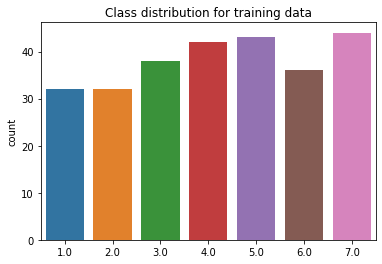

In [ ]:
sns.countplot(x=traffic_train_y,
          order=["1.0", "2.0", "3.0", "4.0", "5.0", "6.0", "7.0"]).set(title="Class distribution for training data")

[Text(0.5, 1.0, 'Class distribution for test data')]

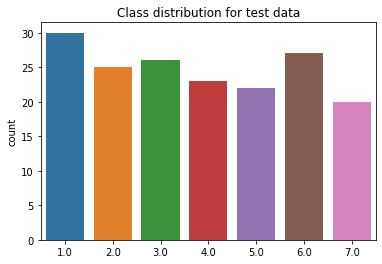

In [ ]:
sns.countplot(x=traffic_test_y,
          order=["1.0", "2.0", "3.0", "4.0", "5.0", "6.0", "7.0"]).set(title="Class distribution for test data")

[Text(0.5, 1.0, 'Class distribution for entire dataset')]

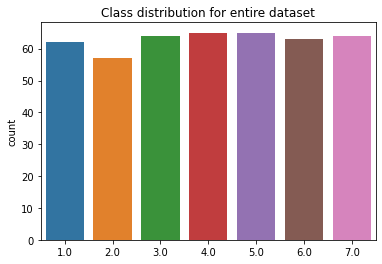

In [ ]:
sns.countplot(x=traffic_y,
          order=["1.0", "2.0", "3.0", "4.0", "5.0", "6.0", "7.0"]).set(title="Class distribution for entire dataset")

#### Observatii
- Asa cum ne asteptam, datele sunt echilibrate in ceea ce priveste frecventa aparitiei fiecarei clase. Acest lucru se datoreaza preluarii datelor pe o perioada contigua, iar etichetele reprezinta zilele saptamanii.

### Alte diagrame sugerate (PEMS-SF)

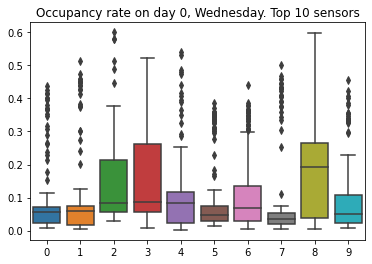

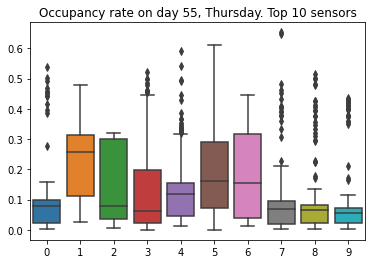

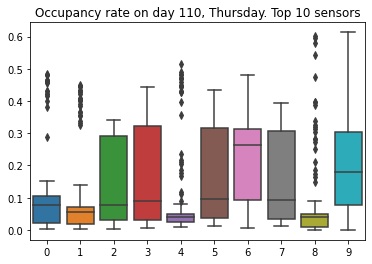

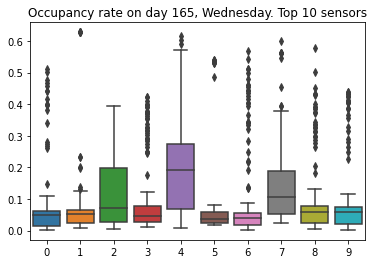

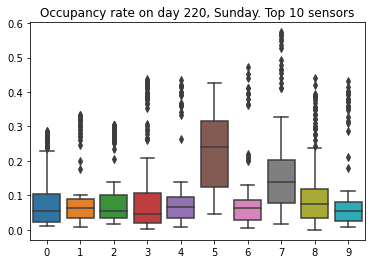

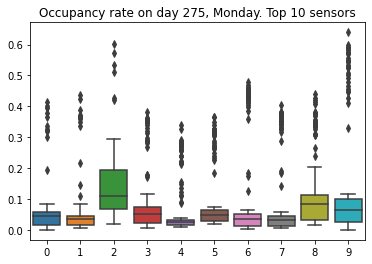

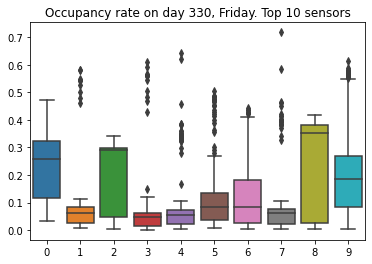

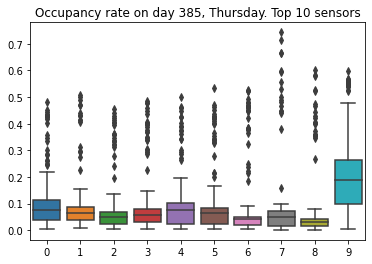

In [ ]:
weekdays = ["", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

def boxplot_top10sensors_traffic(day):
  row = traffic_x.iloc[day]
  deviations = [sr.std(ddof=0) for sr in row]
  indexes = np.argpartition(deviations, -10)[-10:]
  top10df = pd.DataFrame(np.array([sr.tolist() for sr in row.iloc[indexes]]).T)
  weekday = weekdays[int(float((traffic_y[day])))]
  sns.boxplot(data=top10df).set(title=f"Occupancy rate on day {day}, {weekday}. Top 10 sensors")

nr, nc = traffic_x.shape
for day in np.linspace(0, nr, num=8, endpoint=False, dtype=int):
  boxplot_top10sensors_traffic(day)
  plt.show()

#### Observatii
- Exista multi outliers in valorile inregistrare de senzori intr-o zi.
- Exista unele zile (ex. ziua 385) cand datele sunt strans grupate si simetrice pentru toti cei 10 senzori. Ziua 385 este o Joi la fel ca zilele 55 si 110, dar datele arata diferit (cel putin varianta lor). Se poate datora perioadei anului sau exista unei sarbatori.
- Pare ca in timpul saptamanii datele sunt mai putin cuplate si mai nesimetrice decat in weekend.

In [ ]:
nr, nc = traffic_x.shape
daily_mean_occupancy = [[] for _ in range(nc)]

for day in range(nr):
  row = traffic_x.iloc[day]
  means = [sr.mean() for sr in row]
  for i in range(nc):
    daily_mean_occupancy[i].append(means[i])

# Now we have list of 963 lists containing the mean occupancy values for each day for one sensor.
deviations = [np.std(arr) for arr in daily_mean_occupancy]
indexes = np.argpartition(deviations, -10)[-10:]

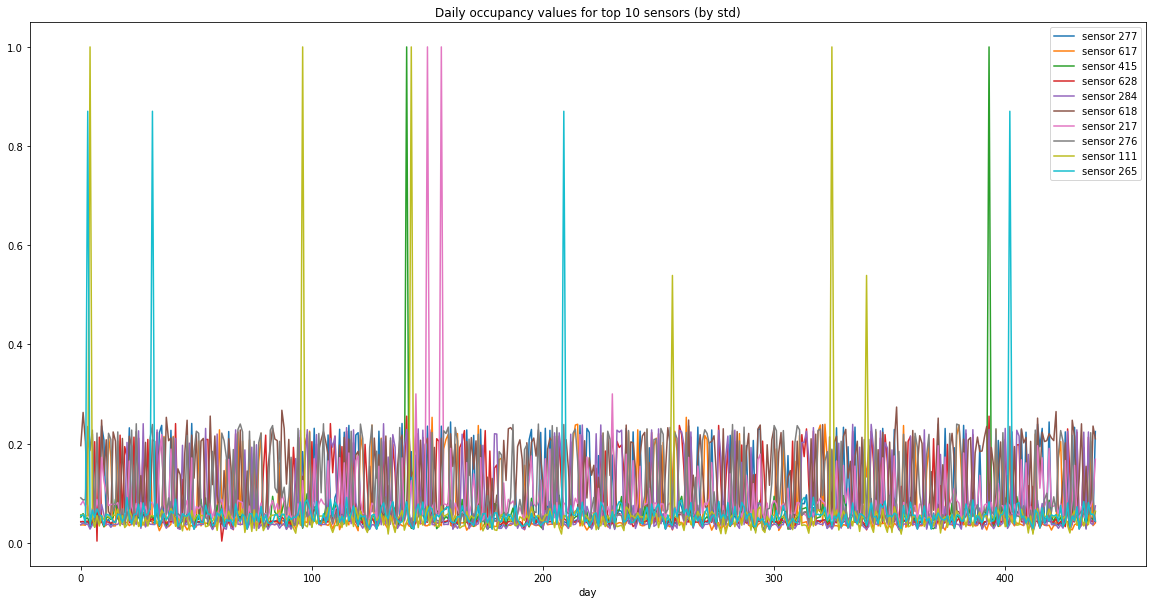

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]

for idx in indexes:
  plt.plot(daily_mean_occupancy[idx], label=f"sensor {idx}")
plt.legend()
plt.title("Daily occupancy values for top 10 sensors (by std)")
plt.xlabel("day")
plt.show()

plt.rcParams['figure.figsize'] = [6.4, 4.8]

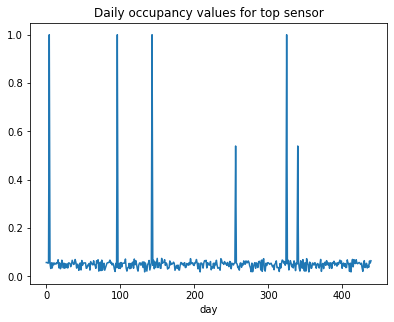

In [ ]:
maxidx = np.argmax(deviations)
plt.plot(daily_mean_occupancy[maxidx])
plt.title("Daily occupancy values for top sensor")
plt.xlabel("day")
plt.show()

#### Observatii
- Din cei 10 senzori cu varianta cea mai mare, doar 5 se observa in grafic ca "ies" dintr-o zona de valori apropiate (0.1-0.2) si ating ocazional intensitati aproape de 1. Acele cresteri bruste pot ajuta la clasificare mai bine decat oscilatie constanta a celorlalanti 5 senzori.
- In partea de jos a graficului, se observa 2 zona de valori parcurse, de grosimi diferite. Valorile unor senzori oscileaza intre 0.05 si 0.2, iar o alta gama de senzori oscileaza intre 0.05 si 0.1. Deci putem folosi atribute bazate pe minimul si maximul valorilor.

## UWaveGestureLibrary

### Analiza echilibrului de clase

[Text(0.5, 1.0, 'Class distribution for training data')]

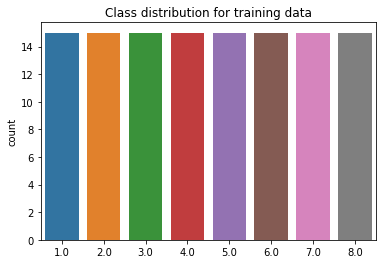

In [ ]:
sns.countplot(x=gestures_train_y,
          order=gestures_y_labels).set(title="Class distribution for training data")

[Text(0.5, 1.0, 'Class distribution for testing data')]

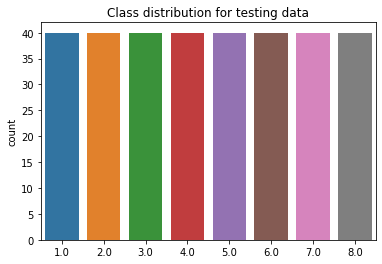

In [ ]:
sns.countplot(x=gestures_test_y,
          order=gestures_y_labels).set(title="Class distribution for testing data")

#### Observatii
Clasele sunt perfect echilibrat distribuite in setul de antrenare. Inseamna ca avem un numar egal de exemple pentru fiecare tip de gest.

### Cate un exemplu pentru fiecare tip de gest

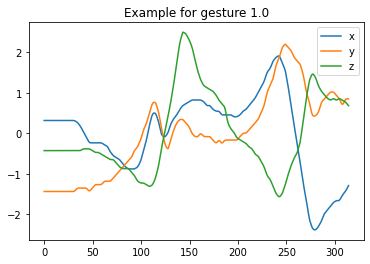

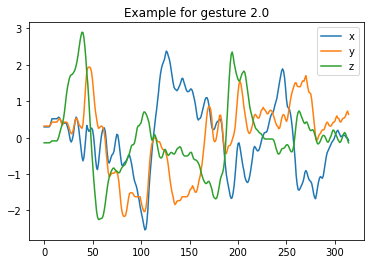

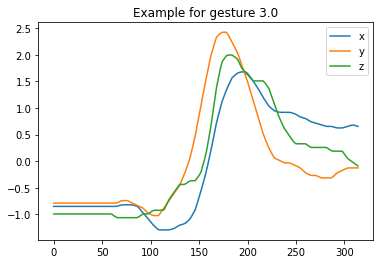

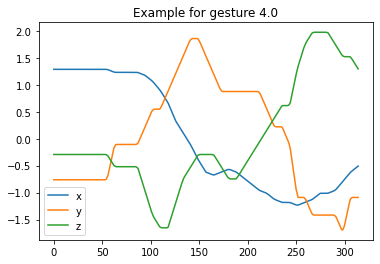

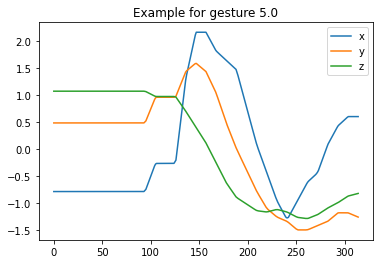

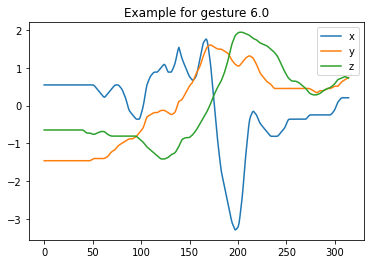

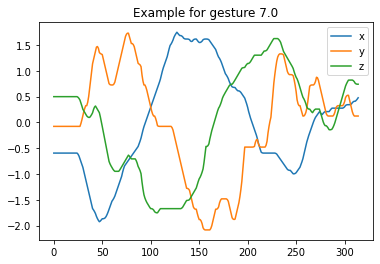

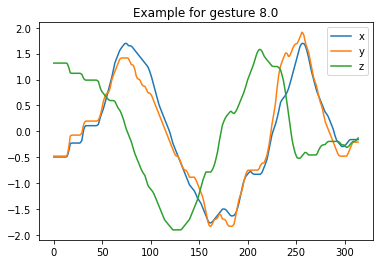

In [ ]:
def plot_example_for_class(x, y, yi):
  try:
    index = np.where(gestures_train_y==yi)[0][0]
  except Exception:
    print(f"Class {yi} not found in y.")
    return None
  
  row = x.iloc[index]
  plt.plot(row[0], label="x")
  plt.plot(row[1], label="y")
  plt.plot(row[2], label="z")
  plt.legend()
  plt.title(f"Example for gesture {yi}")
  plt.show()

for label in gestures_y_labels:
  plot_example_for_class(gestures_train_x, gestures_train_y, label)

#### Observatii
- Se observa asemanari intre gesturi.
 - Gesturile 3 si 4 au miscarea inversa pe x, lucru care se observa si in grafice.
 - Gesturile 5 si 6 au o miscare asemanatoare, inservata pe axa y.
 - Gesturile 7 si 8 au miscarea inversata pe x, la fel pe y si z.
- O sa fie mai dificil de clasificat intre aceste perechi de gesturi ce pot fi confundate.

### Distributia valorilor per fiecare axa per gest

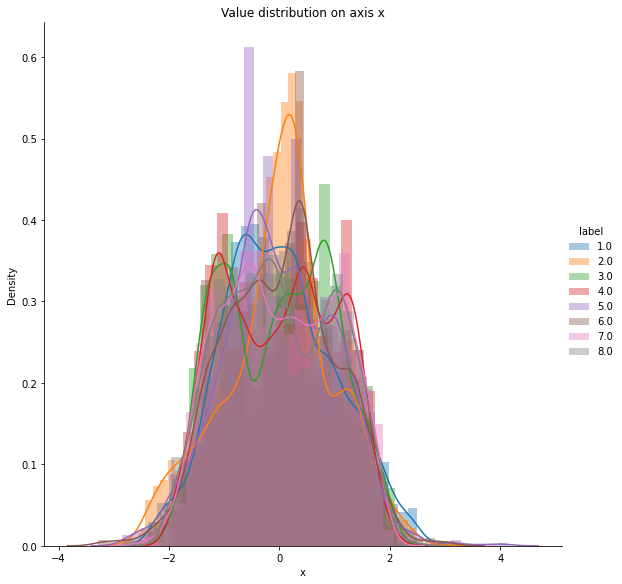

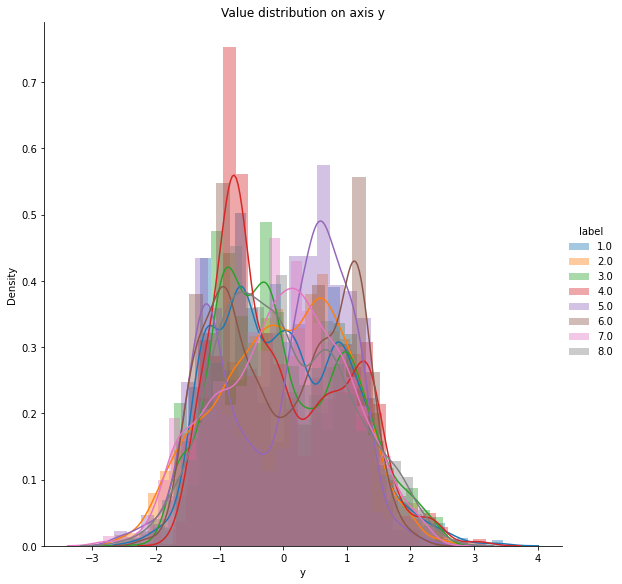

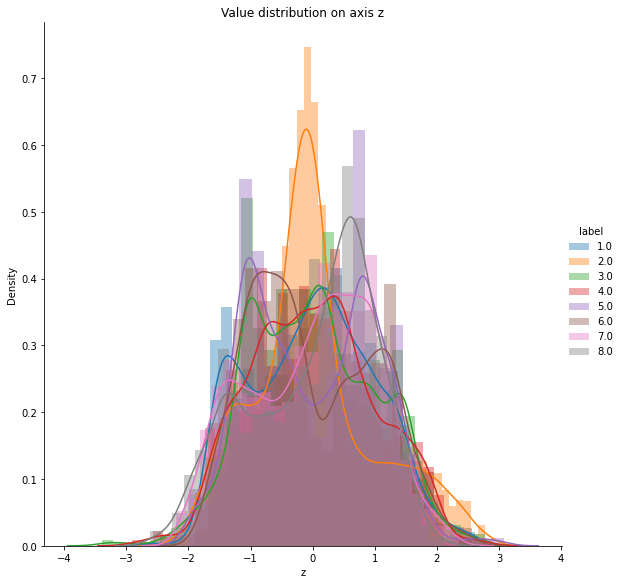

In [ ]:
sns.FacetGrid(gestures_lf, hue="label", height=8).map(sns.distplot, "x").add_legend().set(title="Value distribution on axis x")
sns.FacetGrid(gestures_lf, hue="label", height=8).map(sns.distplot, "y").add_legend().set(title="Value distribution on axis y")
sns.FacetGrid(gestures_lf, hue="label", height=8).map(sns.distplot, "z").add_legend().set(title="Value distribution on axis z")

#### Observatii
- Pe axa x, valorile sunt centrare in 0. Densitatea insa difera.
 - Gestul 2 are valori predominant aproape de 0.
 - Gesturile 7 si 8 au valori ale densitatilor apropiate.
 - Gesturile 3 si 4 au densitati simetrice fata de dreapta 0.
 - Gestul 1 are densitati distinctive.
- Pe axa y, valorile ocupa o plaja mai mare. Se observa aceleasi pattern-uri legate de perechi de gesturi ce seamana, dar sunt oglindite.
- Pe axa z, se observa tot aceleasi pattern-uri.

# Cerinta 2 - PEMS-SF

Pasi:
- Standardizarea datelor (optional - trebuie analizat daca este nevoie sau nu)
- Extragerea atributelor; vor fi extrase un set de atribute per senzor => 963 * x atribute la PEMS-SF
- Selectarea atributelor: Variance Threshold sau Select Percentile (scikit-learn)
- Rularea modelului (SVM, RandomForest, GradientBoostedTrees) si cautarea hiper-parametrilor pe baza de Grid Search cu Cross Validation
- Evaluarea algoritmului:
 - Numarul total de atribute considerate (prin extragere) si numarul total de atribute utilizate in antrenare (prin selectare)
 - Tabel cu media si varianta pentru acuratetea generala de clasificare, precizie/recall/F1 la nivelului fiecarei clase in parte
  - pe linii: configuratia de hiper-parametrii rezultata din GridSearch
  - pe coloane: metricile cerute
 - Pentru cea mai buna varianta a hiper-parametrilor, o matrice de confuzie peste cele 8 clase

## Extragerea atributelor

In [ ]:
def extract_features_traffic(row):
  features = np.array([
    sr.agg(['min', 'max', 'std', 'median', 'skew', 'kurt']).tolist() + [
      np.percentile(sr, 0.25), np.percentile(sr, 0.75), len(argrelextrema(np.array(sr), np.greater))
    ]
    for sr in row
  ]).flatten()
  return features

In [ ]:
nr, nc = traffic_train_x.shape
features_arr = [extract_features_traffic(traffic_train_x.iloc[i]) for i in range(nr)]

In [ ]:
nr, nc = traffic_test_x.shape
test_features_arr = [extract_features_traffic(traffic_test_x.iloc[i]) for i in range(nr)]

In [ ]:
trf_train_x = pd.DataFrame(np.array(features_arr))
trf_train_y = traffic_train_y

trf_test_x = pd.DataFrame(np.array(test_features_arr))
trf_test_y = traffic_test_y

cols = np.array([[
  f"min_{i}", f"max_{i}", f"std_{i}", f"median_{i}", f"skew_{i}", f"kurt_{i}",
  f"perc25_{i}", f"perc75_{i}", f"maxno_{i}"
] for i in range(nc)]).flatten()

trf_train_x.columns = trf_test_x.columns = cols

print(len(features_arr[0]))

8667


Numarul total de atribute considerate, rezultate din extragere: 8667.

## Selectarea atributelor

In [ ]:
def select_features_traffic(train_x, test_x, train_y, threshold=0.1, perc=60):
  # Transform data to [0, 1]
  columns_name = train_x.columns
  scaler = MinMaxScaler()
  train_x = pd.DataFrame(scaler.fit_transform(train_x))
  test_x = pd.DataFrame(scaler.fit_transform(test_x))
  train_x.columns = test_x.columns = columns_name

  # Apply VarianceThreshold selector
  thresholdSel = VarianceThreshold(threshold=threshold)
  thresholdSel = thresholdSel.fit(train_x, train_y)
  cols = thresholdSel.get_support(indices=True).tolist()
  train_x = train_x.iloc[:, cols]
  test_x = test_x.iloc[:, cols]
  
  # Apply SelectPercentile selector
  percentileSel = SelectPercentile(score_func=chi2, percentile=perc)
  percentileSel = percentileSel.fit(train_x, train_y)
  cols = percentileSel.get_support(indices=True).tolist()
  train_x = train_x.iloc[:, cols]
  test_x = test_x.iloc[:, cols]

  return train_x, test_x

In [ ]:
trf_train_x, trf_test_x = select_features_traffic(trf_train_x, trf_test_x, trf_train_y)

In [ ]:
trf_train_x.head()

,min_9,perc25_9,perc75_9,skew_10,min_67,min_71,perc25_71,perc75_71,min_81,min_83,...,perc25_931,perc75_931,std_937,min_942,perc25_942,perc75_942,min_950,perc25_950,perc75_950,perc75_960
0,0.093750,0.094750,0.093049,0.088842,0.900383,0.118367,0.128207,0.136545,0.889952,0.025210,...,0.758376,0.796990,0.878743,0.976431,0.971023,0.943914,0.289655,0.280899,0.278596,0.051846
1,0.058594,0.066693,0.076406,0.088244,0.900383,0.106122,0.107269,0.102409,0.779904,0.008403,...,0.703284,0.697466,0.918881,0.454545,0.456668,0.450420,0.241379,0.248206,0.285978,0.041272
2,0.070312,0.074191,0.078375,0.068539,0.865900,0.122449,0.122093,0.112601,0.875598,0.928571,...,0.660256,0.750766,0.831854,0.932660,0.927567,0.901148,0.048276,0.038705,0.041277,0.071776
3,0.667969,0.674917,0.687451,0.046034,0.881226,0.106122,0.115998,0.125463,0.870813,0.000000,...,0.085328,0.121308,0.030147,0.111111,0.087626,0.038937,0.410345,0.399497,0.389904,0.741594
4,0.734375,0.732702,0.730125,0.113529,0.923372,0.097959,0.103494,0.103533,0.889952,0.000000,...,0.101285,0.104902,0.002564,0.084175,0.067501,0.032150,0.420690,0.409983,0.400363,0.620066


In [ ]:
print(trf_train_x.shape)
print(trf_test_x.shape)

(267, 234)
(173, 234)


Numar total de atribute selectate pentru a fi folosite in antrenare: 234.

## Utilizarea algoritmilor clasici de ML

### SVM

In [ ]:
svc_params = {'kernel': ['linear', 'poly', 'rbf'], 'C': [0.1, 1, 10, 100]}
svc = svm.SVC()
svc_grid = GridSearchCV(svc, svc_params)

In [ ]:
svc_grid.fit(trf_train_x, trf_train_y)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf']})

In [ ]:
print(svc_grid.best_estimator_)

SVC(C=10, kernel='poly')


In [ ]:
svc_scores = pd.DataFrame(svc_grid.cv_results_)
svc_scores.sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.024955,0.005530,0.007315,0.000170,10,poly,"{'C': 10, 'kernel': 'poly'}",0.703704,0.907407,0.773585,0.830189,0.679245,0.778826,0.083377,1
10,0.027013,0.010847,0.013452,0.012292,100,poly,"{'C': 100, 'kernel': 'poly'}",0.703704,0.888889,0.773585,0.849057,0.660377,0.775122,0.085649,2
6,0.023618,0.005919,0.007251,0.000234,10,linear,"{'C': 10, 'kernel': 'linear'}",0.703704,0.814815,0.735849,0.830189,0.754717,0.767855,0.047756,3
9,0.027583,0.011309,0.007390,0.000245,100,linear,"{'C': 100, 'kernel': 'linear'}",0.703704,0.814815,0.735849,0.830189,0.754717,0.767855,0.047756,3
11,0.015125,0.000282,0.005540,0.000057,100,rbf,"{'C': 100, 'kernel': 'rbf'}",0.685185,0.814815,0.792453,0.830189,0.698113,0.764151,0.060540,5
3,0.028764,0.012868,0.008901,0.003097,1,linear,"{'C': 1, 'kernel': 'linear'}",0.592593,0.759259,0.716981,0.792453,0.679245,0.708106,0.069262,6
8,0.026059,0.002832,0.010248,0.000270,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.611111,0.740741,0.679245,0.811321,0.622642,0.693012,0.074999,7
4,0.029236,0.013566,0.007877,0.000715,1,poly,"{'C': 1, 'kernel': 'poly'}",0.574074,0.685185,0.603774,0.735849,0.547170,0.629210,0.070601,8
0,0.034361,0.012006,0.016379,0.003669,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.518519,0.370370,0.396226,0.509434,0.490566,0.457023,0.061414,9
1,0.029613,0.008496,0.009096,0.002834,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.407407,0.259259,0.339623,0.320755,0.320755,0.329560,0.047453,10


In [ ]:
trf_svc_predictions = svc_grid.predict(trf_test_x)

In [ ]:
print(classification_report(trf_test_y, trf_svc_predictions))

              precision    recall  f1-score   support

         1.0       0.93      0.87      0.90        30
         2.0       0.82      0.72      0.77        25
         3.0       0.57      0.62      0.59        26
         4.0       0.50      0.57      0.53        23
         5.0       0.50      0.45      0.48        22
         6.0       0.88      0.78      0.82        27
         7.0       0.76      0.95      0.84        20

    accuracy                           0.71       173
   macro avg       0.71      0.71      0.70       173
weighted avg       0.72      0.71      0.71       173



In [ ]:
svc_matrix = confusion_matrix(trf_test_y, trf_svc_predictions)
svc_matrix_df = pd.DataFrame(
    svc_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7"]
  )
svc_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7
true:1,26,0,0,0,0,0,4
true:2,1,18,4,2,0,0,0
true:3,0,2,16,5,3,0,0
true:4,0,0,6,13,3,1,0
true:5,0,2,2,6,10,2,0
true:6,0,0,0,0,4,21,2
true:7,1,0,0,0,0,0,19


#### Observatii
- Influenta hiperparametrilor
 - In cazul parametrului C de regularizare, valorile 0.1 sau 1 au fost prea mici pentru a obtine un rezultat bun, nu erau suficiente pentru a preveni overfit.
 - In cazul kernelului, au obtinut rezultate mai bune cele polinomiale (de grad 1 sau mai mare).
- Matricea de confuzie
 - Zilele apropiate intre ele pot fi confundate (ex. duminica-luni, vineri-sambata).
 - Se confunda zilele cu program asemenator (zilele de munca - miercuri poate fi condundata cu marti, joi sau vineri; zilele de weekend - sambata poate fi confundat cu vineri sau duminica)

### RandomForest

In [ ]:
rfc_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 4, 6, 7, 8],
    'max_samples': [0.5, 0.75, 0.8, 0.9]
}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, rfc_params)

In [ ]:
rfc_grid.fit(trf_train_x, trf_train_y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 6, 7, 8],
                         'max_samples': [0.5, 0.75, 0.8, 0.9],
                         'n_estimators': [100, 200, 500]})

In [ ]:
print(rfc_grid.best_estimator_)

RandomForestClassifier(max_depth=8, max_samples=0.8, n_estimators=500)


In [ ]:
rfc_scores = pd.DataFrame(rfc_grid.cv_results_)
rfc_scores.sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
56,1.083638,0.008158,0.061882,0.004936,8,0.8,500,"{'max_depth': 8, 'max_samples': 0.8, 'n_estima...",0.870370,0.907407,0.924528,0.962264,0.867925,0.906499,0.035296,1
53,1.070977,0.004156,0.066398,0.012700,8,0.75,500,"{'max_depth': 8, 'max_samples': 0.75, 'n_estim...",0.870370,0.888889,0.943396,0.962264,0.849057,0.902795,0.043168,2
58,0.455887,0.008033,0.027429,0.004633,8,0.9,200,"{'max_depth': 8, 'max_samples': 0.9, 'n_estima...",0.870370,0.888889,0.924528,0.943396,0.886792,0.902795,0.026913,2
42,0.216806,0.003926,0.016042,0.002359,7,0.8,100,"{'max_depth': 7, 'max_samples': 0.8, 'n_estima...",0.870370,0.925926,0.943396,0.886792,0.886792,0.902655,0.027375,4
59,1.117113,0.002492,0.062654,0.006194,8,0.9,500,"{'max_depth': 8, 'max_samples': 0.9, 'n_estima...",0.870370,0.888889,0.924528,0.943396,0.867925,0.899022,0.030034,5
41,1.048132,0.011123,0.063152,0.006166,7,0.75,500,"{'max_depth': 7, 'max_samples': 0.75, 'n_estim...",0.870370,0.888889,0.924528,0.943396,0.867925,0.899022,0.030034,5
35,1.058812,0.004281,0.057331,0.002214,6,0.9,500,"{'max_depth': 6, 'max_samples': 0.9, 'n_estima...",0.870370,0.888889,0.943396,0.943396,0.849057,0.899022,0.038362,5
51,0.218186,0.003763,0.015632,0.002233,8,0.75,100,"{'max_depth': 8, 'max_samples': 0.75, 'n_estim...",0.870370,0.907407,0.905660,0.943396,0.867925,0.898952,0.027826,8
55,0.436054,0.003930,0.026656,0.002034,8,0.8,200,"{'max_depth': 8, 'max_samples': 0.8, 'n_estima...",0.870370,0.870370,0.924528,0.943396,0.867925,0.895318,0.032125,9
34,0.426761,0.009796,0.027371,0.003753,6,0.9,200,"{'max_depth': 6, 'max_samples': 0.9, 'n_estima...",0.870370,0.870370,0.905660,0.962264,0.867925,0.895318,0.036288,9


In [ ]:
trf_rfc_predictions = rfc_grid.predict(trf_test_x)

In [ ]:
print(classification_report(trf_test_y, trf_rfc_predictions))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        30
         2.0       0.89      0.96      0.92        25
         3.0       0.90      0.73      0.81        26
         4.0       0.77      0.87      0.82        23
         5.0       0.82      0.82      0.82        22
         6.0       0.93      0.93      0.93        27
         7.0       1.00      1.00      1.00        20

    accuracy                           0.90       173
   macro avg       0.90      0.90      0.90       173
weighted avg       0.90      0.90      0.90       173



In [ ]:
rfc_matrix = confusion_matrix(trf_test_y, trf_rfc_predictions)
rfc_matrix_df = pd.DataFrame(
    rfc_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7"]
  )
rfc_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7
true:1,30,0,0,0,0,0,0
true:2,0,24,1,0,0,0,0
true:3,0,3,20,3,0,0,0
true:4,0,0,2,20,1,0,0
true:5,0,0,0,1,18,3,0
true:6,0,0,0,0,2,25,0
true:7,0,0,0,0,0,0,20


#### Observatii
- Influenta hiperparametrilor
 - Adancimea maxima a unui arbore influenteaza cel mai mult rezultatele. Instantele cu max_depth cel mai mare au obtinut cele mai buna acurateti.
 - Ceilalti hiperparametrii variaza in cazul unor instante cu rezultate similare. Se distinge doar o imbunatatire pentru numar mare de arbori si pentru un procent >= 0.75 din input folosit la antrenare.
- Matricea de confuzie
 - Unele zile nu pot fi confundate (ex. luni, duminica) probabil datorita unor trend-uri al traficului pentru acele zile.
 - Zilele din mijlocul saptamanii pot fi confundate intre ele (ex. marti-miercuri-joi-vineri), dar mai putin ca la modelul SVM.

### GradientBoosted Trees

In [ ]:
gbt_params = {
    'n_estimator': [100, 200, 500],
    'max_depth': [2, 4, 7, 8],
    'learning_rate': [0.1, 0.01, 0.05],
    'subsample': [0.5, 0.75, 0.9]
}
gbt = xgb.XGBClassifier()
gbt_grid = GridSearchCV(gbt, gbt_params)

In [ ]:
gbt_grid.fit(trf_train_x, trf_train_y)

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [2, 4, 7, 8],
                         'n_estimator': [100, 200, 500],
                         'subsample': [0.5, 0.75, 0.9]})

In [ ]:
print(gbt_grid.best_estimator_)

XGBClassifier(max_depth=7, n_estimator=100, objective='multi:softprob',
              subsample=0.9)


In [ ]:
gbt_scores = pd.DataFrame(gbt_grid.cv_results_)
gbt_scores.sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimator,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,2.203070,0.028522,0.005793,0.000063,0.1,7,500,0.9,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.907407,0.907407,0.886792,0.924528,0.943396,0.913906,0.018985,1
23,2.208821,0.026750,0.005850,0.000138,0.1,7,200,0.9,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.907407,0.907407,0.886792,0.924528,0.943396,0.913906,0.018985,1
20,2.237827,0.080871,0.005843,0.000053,0.1,7,100,0.9,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.907407,0.907407,0.886792,0.924528,0.943396,0.913906,0.018985,1
25,2.151623,0.023157,0.006128,0.000342,0.1,7,500,0.75,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.907407,0.888889,0.924528,0.905660,0.924528,0.910203,0.013365,4
22,2.261876,0.261705,0.005920,0.000106,0.1,7,200,0.75,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.907407,0.888889,0.924528,0.905660,0.924528,0.910203,0.013365,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,1.479188,0.005425,0.005482,0.000063,0.01,2,500,0.75,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.796296,0.833333,0.735849,0.867925,0.849057,0.816492,0.046692,103
37,1.478145,0.004870,0.005512,0.000072,0.01,2,100,0.75,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.796296,0.833333,0.735849,0.867925,0.849057,0.816492,0.046692,103
38,1.518376,0.005658,0.005379,0.000059,0.01,2,100,0.9,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.814815,0.814815,0.716981,0.830189,0.849057,0.805171,0.045859,106
41,1.517887,0.011869,0.005406,0.000039,0.01,2,200,0.9,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.814815,0.814815,0.716981,0.830189,0.849057,0.805171,0.045859,106


In [ ]:
trf_gbt_predictions = gbt_grid.predict(trf_test_x)

In [ ]:
print(classification_report(trf_test_y, trf_gbt_predictions))

              precision    recall  f1-score   support

         1.0       1.00      0.83      0.91        30
         2.0       0.77      0.96      0.86        25
         3.0       0.95      0.77      0.85        26
         4.0       0.59      0.57      0.58        23
         5.0       0.68      0.77      0.72        22
         6.0       1.00      0.93      0.96        27
         7.0       0.83      1.00      0.91        20

    accuracy                           0.83       173
   macro avg       0.83      0.83      0.83       173
weighted avg       0.85      0.83      0.83       173



In [ ]:
gbt_matrix = confusion_matrix(trf_test_y, trf_gbt_predictions)
gbt_matrix_df = pd.DataFrame(
    gbt_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7"]
  )
gbt_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7
true:1,25,4,0,0,0,0,1
true:2,0,24,0,1,0,0,0
true:3,0,0,20,5,1,0,0
true:4,0,2,1,13,7,0,0
true:5,0,1,0,3,17,0,1
true:6,0,0,0,0,0,25,2
true:7,0,0,0,0,0,0,20


#### Observatii
- Influenta hiperparametrilor
 - Learning rate preferat este 0.1, probabil 0.01 sau 0.05 sunt prea mici pentru a converge in timp.
 - Adancimea maxima a arborilor are valoarea optima 7. Inseamna ca e nevoie de o adancime suficient de mare, dar cresterea la 8 nu aduce o imbunatatire.
 - Procentul pentru sample-urile folosite in antrenare trebuie sa fie din gama de valori mai mari (0.9, 0.75).
 - Numarul de arbori nu influenteaza performantele. Cel mai probabil valoarea minima (100) este suficienta.
- Matricea de confuzie
 - Unele zile nu pot fi confundate (ex. luni, marti) probabil datorita unor trend-uri al traficului pentru acele zile.
 - Exista confuzii intre clase pentru zile apropiate, zile din mijlocul saptamanii sau weekend.

## Rezultate

|                                                                  | General |         |         |         | 1     |       |       | 2        |          |          | 3        |          |          | 4        |          |          | 5        |          |          | 6     |          |          | 7     |       |       |
|------------------------------------------------------------------|---------|---------|---------|---------|-------|-------|-------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|-------|----------|----------|-------|-------|-------|
| Algoritm                                                         | A       | P       | R       | F1      | P     | R     | F1    | P        | R        | F1       | P        | R        | F1       | P        | R        | F1       | P        | R        | F1       | P     | R        | F1       | P     | R     | F1    |
| SVC C=10 kernel='poly'                                           | 0.71    | 0.72    | 0.71    | 0.71    | 0.93  | 0.87  | 0.90  | 0.82     | 0.72     | 0.77     | 0.57     | 0.62     | 0.59     | 0.50     | 0.57     | 0.53     | 0.50     | 0.45     | 0.48     | 0.88  | 0.78     | 0.82     | 0.76  | 0.95  | 0.84  |
| RandomForest max_depth=7 max_samples=0.9 n_estimators=500        | **0.9** | **0.9** | **0.9** | **0.9** | **1** | **1** | **1** | **0.89** | **0.96** | **0.92** | 0.9      | 0.73     | 0.81     | **0.77** | **0.87** | **0.82** | **0.82** | **0.82** | **0.82** | 0.93  | **0.93** | 0.93     | **1** | **1** | **1** |
| GradientBoosted Trees max_depth=7 n_estimators=100 subsample=0.9 | 0.83    | 0.85    | 0.83    | 0.83    | **1** | 0.83  | 0.91  | 0.77     | **0.96** | 0.86     | **0.95** | **0.77** | **0.85** | 0.59     | 0.57     | 0.58     | 0.68     | 0.77     | 0.72     | **1** | **0.93** | **0.96** | 0.83  | **1** | 0.91  |

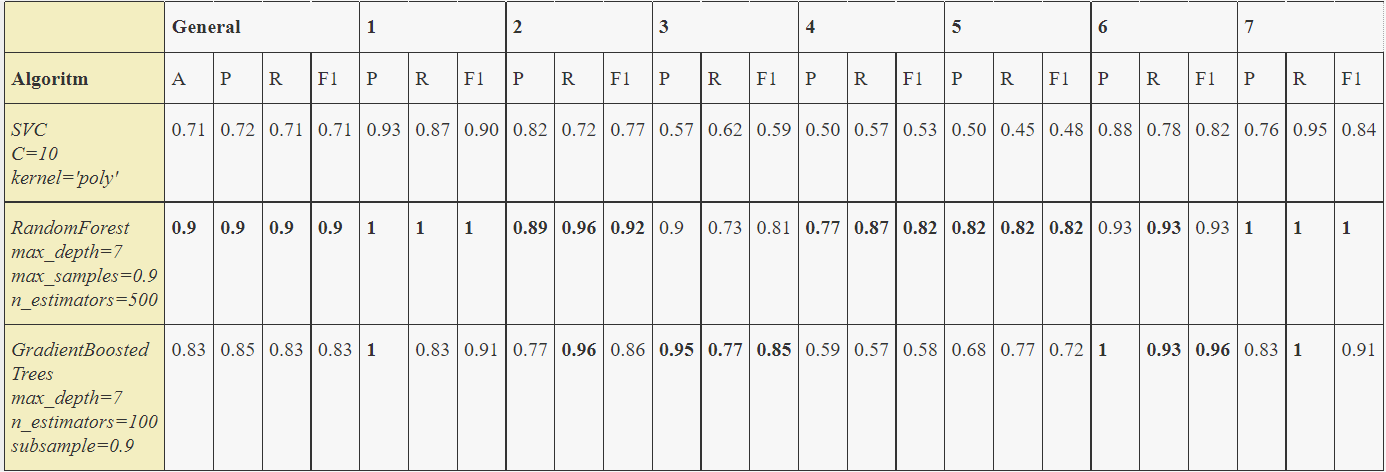

In [ ]:
Image(path + "results_pems-sf.PNG")

#### Observatii
- Metoda de Random Forest are cele mai bune rezultate. Divizarea exemplelor dupa atribute este o metoda buna.
- SVC are cele mai proaste rezultate. Datele nu sunt usor-separabile printr-o margine de separare.
- Unele zile se disting mai usor (cum ar fi zilele de weekend - datorita unui trafic mai mare si zilele de Luni si Marti - posibil datorita unui trafic specific). Zilele de Joi si Vineri au cele mai mici valori la metrici, o posibila explicatie ar fi asemanarea intre ele cand vine vorba de obiceiurile oamenilor.

# Cerinta 2 - UWaveGestures

## Extragere atribute

In [9]:
window = 70
slide = 35

In [10]:
def extract_features_gestures(row):
  features = []
  # create windows
  for idx in range(0, 315 - window + 1, slide):
    for sr in row:
      arr = np.array(sr.tolist()[idx:(idx + window)])
      features += [
        arr.mean(),                                       # mean
        arr.std(),                                        # std dev
        np.mean(np.absolute(arr - np.mean(arr))),         # avg absolute diff
        arr.min(),                                        # min
        arr.max(),                                        # max
        arr.max() - arr.min(),                            # max-min diff
        np.median(arr),                                   # median
        np.median(np.absolute(arr - np.median(arr))),     # median abs dev
        np.percentile(arr, 75) - np.percentile(arr, 25),  # interquartile range
        np.sum(arr < 0),                                  # negative count
        np.sum(arr > 0),                                  # positive count
        np.sum(arr > arr.mean()),                         # values above mean
        len(find_peaks(arr)[0]),                          # number of peaks
        skew(arr),                                        # skewness
        kurtosis(arr),                                    # kurtosis
        np.sum(arr**2)/window                            # energy
      ]
    # add avg resultant mean
    features.append(np.mean((row[0]**2 + row[1]**2 + row[2]**2)**0.5))
    # add signal magnitude area
    features.append(np.sum(abs(row[0])/window) + np.sum(abs(row[1])/window) + np.sum(abs(row[2])/window))
  return features

In [11]:
nr, nc = gestures_train_x.shape
features_arr = [extract_features_gestures(gestures_train_x.iloc[i]) for i in range(nr)]

In [12]:
nr, nc = gestures_test_x.shape
test_features_arr = [extract_features_gestures(gestures_test_x.iloc[i]) for i in range(nr)]

In [13]:
gst_train_x = pd.DataFrame(features_arr)
gst_train_y = gestures_train_y

gst_test_x = pd.DataFrame(test_features_arr)
gst_test_y = gestures_test_y

print(len(features_arr[0]))

400


Numarul total de atribute considerate, rezultate din extragere: 400.

## Selectare atribute

Numarul de atribute considerate este deja suficient de mic incat am putea lucra cu toate. Dar numerele sunt de ordine diferite, deci trebuie standardizate si eliminate cele care nu indeplinesc un minim de varianta.

In [14]:
def select_features_gestures(train_x, test_x, train_y, threshold=0.1):
  # Standardize data
  scaler = MinMaxScaler()
  train_x = pd.DataFrame(scaler.fit_transform(train_x))
  test_x = pd.DataFrame(scaler.fit_transform(test_x))

  # Apply VarianceThreshold selector
  thresholdSel = VarianceThreshold(threshold=threshold)
  thresholdSel = thresholdSel.fit(train_x, train_y)
  cols = thresholdSel.get_support(indices=True).tolist()
  train_x = train_x.iloc[:, cols]
  test_x = test_x.iloc[:, cols]

  return train_x, test_x

In [15]:
gst_train_x, gst_test_x = select_features_gestures(gst_train_x, gst_test_x, gst_train_y, 0.1)

In [16]:
gst_train_x

,9,10,25,26,41,42,59,60,75,76,...,325,326,341,342,359,360,375,376,391,392
0,0.314286,0.685714,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.857143,0.142857,...,0.000000,1.000000,0.000000,1.000000,0.814286,0.185714,0.071429,0.928571,0.000000,1.000000
1,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
2,0.000000,1.000000,0.985714,0.014286,0.000000,1.000000,0.000000,1.000000,0.485714,0.514286,...,0.942857,0.057143,1.000000,0.000000,0.714286,0.285714,1.000000,0.000000,1.000000,0.000000
3,0.400000,0.600000,0.000000,1.000000,0.000000,1.000000,0.900000,0.100000,0.000000,1.000000,...,0.400000,0.600000,0.642857,0.357143,0.000000,1.000000,0.614286,0.385714,0.357143,0.642857
4,0.000000,1.000000,0.728571,0.271429,0.714286,0.285714,0.000000,1.000000,0.228571,0.771429,...,0.800000,0.200000,0.242857,0.757143,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,0.285714,0.714286,1.000000,0.000000,0.914286,0.085714,0.785714,0.214286,1.000000,0.000000,...,0.885714,0.114286,0.871429,0.128571,0.271429,0.728571,1.000000,0.000000,0.914286,0.085714
892,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.642857,0.357143,0.614286,0.385714,...,0.000000,1.000000,0.100000,0.900000,0.857143,0.142857,0.257143,0.742857,0.000000,1.000000
893,0.000000,1.000000,0.228571,0.771429,0.000000,1.000000,0.057143,0.942857,0.371429,0.628571,...,0.342857,0.657143,0.357143,0.642857,0.342857,0.657143,0.028571,0.971429,0.528571,0.471429
894,0.285714,0.714286,0.000000,1.000000,0.000000,1.000000,0.785714,0.214286,0.300000,0.700000,...,0.000000,1.000000,0.000000,1.000000,0.928571,0.071429,0.471429,0.528571,0.371429,0.628571


In [17]:
print(gst_train_x.shape)
print(gst_test_x.shape)

(896, 48)
(3582, 48)


Numar total de atribute selectate pentru a fi folosite in antrenare: 48.

## Utilizarea algoritmilor clasici de ML

### SVM

In [ ]:
svc_params = {'kernel': ['linear', 'poly', 'rbf'], 'C': [0.1, 1, 10, 100]}
svc = svm.SVC()
svc_grid = GridSearchCV(svc, svc_params)

In [ ]:
svc_grid.fit(gst_train_x, gst_train_y)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf']})

In [ ]:
print(svc_grid.best_estimator_)

SVC(C=1, kernel='poly')


In [ ]:
svc_scores = pd.DataFrame(svc_grid.cv_results_)
svc_scores.sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.003200,0.000086,0.001695,0.000017,1,poly,"{'C': 1, 'kernel': 'poly'}",1.000000,0.875000,0.916667,0.833333,0.958333,0.916667,0.058926,1
7,0.003152,0.000058,0.001690,0.000013,10,poly,"{'C': 10, 'kernel': 'poly'}",1.000000,0.875000,0.916667,0.833333,0.958333,0.916667,0.058926,1
10,0.003173,0.000070,0.001696,0.000019,100,poly,"{'C': 100, 'kernel': 'poly'}",1.000000,0.875000,0.916667,0.833333,0.958333,0.916667,0.058926,1
5,0.003669,0.000051,0.001843,0.000045,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.958333,0.833333,0.916667,0.916667,0.916667,0.908333,0.040825,4
8,0.004447,0.001032,0.002213,0.000538,10,rbf,"{'C': 10, 'kernel': 'rbf'}",1.000000,0.875000,0.958333,0.791667,0.916667,0.908333,0.071686,4
11,0.003718,0.000059,0.001888,0.000106,100,rbf,"{'C': 100, 'kernel': 'rbf'}",1.000000,0.875000,0.958333,0.791667,0.916667,0.908333,0.071686,4
1,0.003636,0.000778,0.002067,0.000473,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.958333,0.833333,0.958333,0.916667,0.875000,0.908333,0.048591,7
2,0.003672,0.000415,0.001876,0.000029,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.958333,0.750000,0.916667,0.875000,0.875000,0.875000,0.069722,8
3,0.003586,0.000693,0.001745,0.000137,1,linear,"{'C': 1, 'kernel': 'linear'}",0.875000,0.833333,0.916667,0.875000,0.833333,0.866667,0.031180,9
6,0.003139,0.000066,0.001721,0.000065,10,linear,"{'C': 10, 'kernel': 'linear'}",0.791667,0.833333,0.916667,0.833333,0.833333,0.841667,0.040825,10


In [ ]:
gst_svc_predictions = svc_grid.predict(gst_test_x)

In [ ]:
print(classification_report(gst_test_y, gst_svc_predictions))

              precision    recall  f1-score   support

         1.0       0.80      0.88      0.83        40
         2.0       0.85      0.97      0.91        40
         3.0       0.88      0.90      0.89        40
         4.0       0.96      0.65      0.78        40
         5.0       0.76      0.88      0.81        40
         6.0       0.73      0.80      0.76        40
         7.0       0.97      0.80      0.88        40
         8.0       0.97      0.95      0.96        40

    accuracy                           0.85       320
   macro avg       0.86      0.85      0.85       320
weighted avg       0.86      0.85      0.85       320



In [ ]:
svc_matrix = confusion_matrix(gst_test_y, gst_svc_predictions)
svc_matrix_df = pd.DataFrame(
    svc_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7", "true:8"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7", "pred:8"]
  )
svc_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7,pred:8
true:1,35,0,0,0,0,5,0,0
true:2,0,39,0,0,0,0,1,0
true:3,0,0,36,0,4,0,0,0
true:4,1,1,0,26,6,5,0,1
true:5,2,0,1,0,35,2,0,0
true:6,2,2,3,1,0,32,0,0
true:7,2,4,1,0,1,0,32,0
true:8,2,0,0,0,0,0,0,38


#### Observatii
- Influenta hiperparametrilor
 - Hiperparametrul C nu influenteaza mult rezultatele.
 - Kernelul polinomial duce la cele mai mari acurateti. Kernelul liniar nu este suficient pentru a separa clasele.
- Matricea de confuzie
 - Cum se observa si vizual, gestul 2 este cel mai greu de confundat.
 - Gesturi cu asemanari (mai ales pe anumite axe) pot fi confundate.
 - Perechi de gesturi care par oglindite sunt clasificate corect si nu sunt confundate, cel mai probabil datorita extragerii de atribute signifiante.

### RandomForest

In [ ]:
rfc_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 4, 6, 8, None],
    'max_samples': [0.5, 0.75, 0.8, 0.9]
}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, rfc_params)

In [ ]:
rfc_grid.fit(gst_train_x, gst_train_y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, None],
                         'max_samples': [0.5, 0.75, 0.8, 0.9],
                         'n_estimators': [100, 200, 500]})

In [ ]:
print(rfc_grid.best_estimator_)

RandomForestClassifier(max_depth=6, max_samples=0.9, n_estimators=500)


In [ ]:
rfc_results = pd.DataFrame(rfc_grid.cv_results_)
rfc_results.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,0.679017,0.008934,0.058975,0.005240,6,0.9,500,"{'max_depth': 6, 'max_samples': 0.9, 'n_estima...",1.000000,0.750000,0.916667,0.875000,0.875000,0.883333,0.080795,1
58,0.272708,0.007063,0.024270,0.003327,None,0.9,200,"{'max_depth': None, 'max_samples': 0.9, 'n_est...",1.000000,0.750000,0.916667,0.875000,0.875000,0.883333,0.080795,1
29,0.666942,0.012837,0.057558,0.003134,6,0.75,500,"{'max_depth': 6, 'max_samples': 0.75, 'n_estim...",1.000000,0.750000,0.916667,0.833333,0.875000,0.875000,0.083333,3
56,0.679778,0.008568,0.053861,0.001800,None,0.8,500,"{'max_depth': None, 'max_samples': 0.8, 'n_est...",1.000000,0.750000,0.875000,0.875000,0.875000,0.875000,0.079057,3
47,0.680262,0.008149,0.056711,0.003833,8,0.9,500,"{'max_depth': 8, 'max_samples': 0.9, 'n_estima...",0.958333,0.750000,0.916667,0.875000,0.875000,0.875000,0.069722,3
43,0.268898,0.003843,0.022066,0.000271,8,0.8,200,"{'max_depth': 8, 'max_samples': 0.8, 'n_estima...",0.958333,0.750000,0.916667,0.875000,0.875000,0.875000,0.069722,3
28,0.267475,0.007068,0.023822,0.002376,6,0.75,200,"{'max_depth': 6, 'max_samples': 0.75, 'n_estim...",1.000000,0.750000,0.875000,0.875000,0.875000,0.875000,0.079057,3
59,0.689174,0.011491,0.062822,0.007211,None,0.9,500,"{'max_depth': None, 'max_samples': 0.9, 'n_est...",0.958333,0.750000,0.916667,0.875000,0.875000,0.875000,0.069722,3
49,0.261353,0.006511,0.025314,0.002055,None,0.5,200,"{'max_depth': None, 'max_samples': 0.5, 'n_est...",1.000000,0.750000,0.833333,0.875000,0.875000,0.866667,0.080795,9
32,0.664352,0.006789,0.055589,0.002713,6,0.8,500,"{'max_depth': 6, 'max_samples': 0.8, 'n_estima...",0.958333,0.750000,0.875000,0.875000,0.875000,0.866667,0.066667,9


In [ ]:
gst_rfc_predictions = rfc_grid.predict(gst_test_x)

In [ ]:
print(classification_report(gst_test_y, gst_rfc_predictions))

              precision    recall  f1-score   support

         1.0       0.78      0.88      0.82        40
         2.0       0.72      0.97      0.83        40
         3.0       0.79      0.93      0.85        40
         4.0       0.96      0.62      0.76        40
         5.0       0.70      0.88      0.78        40
         6.0       0.80      0.60      0.69        40
         7.0       0.96      0.68      0.79        40
         8.0       0.93      0.93      0.93        40

    accuracy                           0.81       320
   macro avg       0.83      0.81      0.81       320
weighted avg       0.83      0.81      0.81       320



In [ ]:
rfc_matrix = confusion_matrix(gst_test_y, gst_rfc_predictions)
rfc_matrix_df = pd.DataFrame(
    rfc_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7", "true:8"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7", "pred:8"]
  )
rfc_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7,pred:8
true:1,34,1,0,0,0,5,0,0
true:2,0,39,0,0,0,0,1,0
true:3,0,0,34,0,4,2,0,0
true:4,0,1,0,25,9,2,0,3
true:5,2,0,1,0,34,3,0,0
true:6,4,0,6,1,0,29,0,0
true:7,1,8,1,0,0,0,30,0
true:8,2,0,0,0,0,0,0,38


#### Observatii
- Influenta hiperparametrilor
 - Scorul variaza de la 0.88 la 0.82 indiferent de hiperparametrii.
 - Par de preferat: adancime maxima mai mare (sau None, i.e. oricat este nevoie), procent mare folosit la antrenare, numar mare de arbori. Desi sunt obtinute scoruri favorabile si in variatiuni diferite ale hiperparametrilor.
- Matricea de confuzie
 - Cum se observa si vizual, gestul 2 este cel mai greu de confundat.
 - Cateva confuzii intre gesturi ce arata similar pe una sau 2 axe.

### GradientBoosted Trees

In [ ]:
gbt_params = {
    'n_estimator': [100, 200, 500],
    'max_depth': [2, 4, 7, 8],
    'learning_rate': [0.1, 0.01, 0.05],
    'subsample': [0.5, 0.75, 0.9]
}
gbt = xgb.XGBClassifier()
gbt_grid = GridSearchCV(gbt, gbt_params)

In [ ]:
gbt_grid.fit(gst_train_x, gst_train_y)

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [2, 4, 7, 8],
                         'n_estimator': [100, 200, 500],
                         'subsample': [0.5, 0.75, 0.9]})

In [ ]:
print(gbt_grid.best_estimator_)

XGBClassifier(max_depth=4, n_estimator=100, objective='multi:softprob',
              subsample=0.5)


In [ ]:
gbt_results = pd.DataFrame(gbt_grid.cv_results_)
gbt_results.sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimator,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,0.313751,0.020005,0.003919,0.000522,0.1,8,500,0.5,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.916667,0.750000,0.791667,0.833333,0.875000,0.833333,0.058926,1
30,0.301095,0.015584,0.003641,0.000043,0.1,8,200,0.5,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.916667,0.750000,0.791667,0.833333,0.875000,0.833333,0.058926,1
27,0.493104,0.156060,0.003698,0.000052,0.1,8,100,0.5,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.916667,0.750000,0.791667,0.833333,0.875000,0.833333,0.058926,1
24,0.276952,0.011079,0.003385,0.000346,0.1,7,500,0.5,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.916667,0.750000,0.791667,0.833333,0.875000,0.833333,0.058926,1
21,0.328695,0.040905,0.003578,0.000075,0.1,7,200,0.5,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.916667,0.750000,0.791667,0.833333,0.875000,0.833333,0.058926,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.271905,0.005733,0.002439,0.000074,0.01,8,500,0.9,"{'learning_rate': 0.01, 'max_depth': 8, 'n_est...",0.750000,0.708333,0.750000,0.750000,0.833333,0.758333,0.040825,100
59,0.272551,0.005690,0.002408,0.000021,0.01,7,200,0.9,"{'learning_rate': 0.01, 'max_depth': 7, 'n_est...",0.750000,0.708333,0.750000,0.750000,0.833333,0.758333,0.040825,100
62,0.274378,0.004941,0.002560,0.000118,0.01,7,500,0.9,"{'learning_rate': 0.01, 'max_depth': 7, 'n_est...",0.750000,0.708333,0.750000,0.750000,0.833333,0.758333,0.040825,100
65,0.273575,0.007905,0.002713,0.000446,0.01,8,100,0.9,"{'learning_rate': 0.01, 'max_depth': 8, 'n_est...",0.750000,0.708333,0.750000,0.750000,0.833333,0.758333,0.040825,100


In [ ]:
gst_gbt_predictions = gbt_grid.predict(gst_test_x)

In [ ]:
print(classification_report(gst_test_y, gst_gbt_predictions))

              precision    recall  f1-score   support

         1.0       0.70      0.82      0.76        40
         2.0       0.84      0.93      0.88        40
         3.0       0.79      0.82      0.80        40
         4.0       0.88      0.57      0.70        40
         5.0       0.74      0.85      0.79        40
         6.0       0.80      0.70      0.75        40
         7.0       0.86      0.62      0.72        40
         8.0       0.71      0.90      0.79        40

    accuracy                           0.78       320
   macro avg       0.79      0.78      0.77       320
weighted avg       0.79      0.78      0.77       320



In [ ]:
gbt_matrix = confusion_matrix(gst_test_y, gst_gbt_predictions)
gbt_matrix_df = pd.DataFrame(
    rfc_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7", "true:8"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7", "pred:8"]
  )
gbt_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7,pred:8
true:1,34,1,0,0,0,5,0,0
true:2,0,39,0,0,0,0,1,0
true:3,0,0,34,0,4,2,0,0
true:4,0,1,0,25,9,2,0,3
true:5,2,0,1,0,34,3,0,0
true:6,4,0,6,1,0,29,0,0
true:7,1,8,1,0,0,0,30,0
true:8,2,0,0,0,0,0,0,38


#### Observatii
- Influenta hiperparametrilor
 - Learning rate optim este 0.1. Celelalte variante (0.01 si 0.05) probabil faceau modelul sa convearga mult prea incet.
 - E nevoie de o adancime a arborilor mare.
 - Numarul de arbori nu influenteaza prea mult scorul.
- Matricea de confuzie
 - Cum se observa si vizual, gestul 2 este cel mai greu de confundat.
 - Cateva confuzii intre gesturi ce arata similar pe una sau 2 axe.

## Rezultate

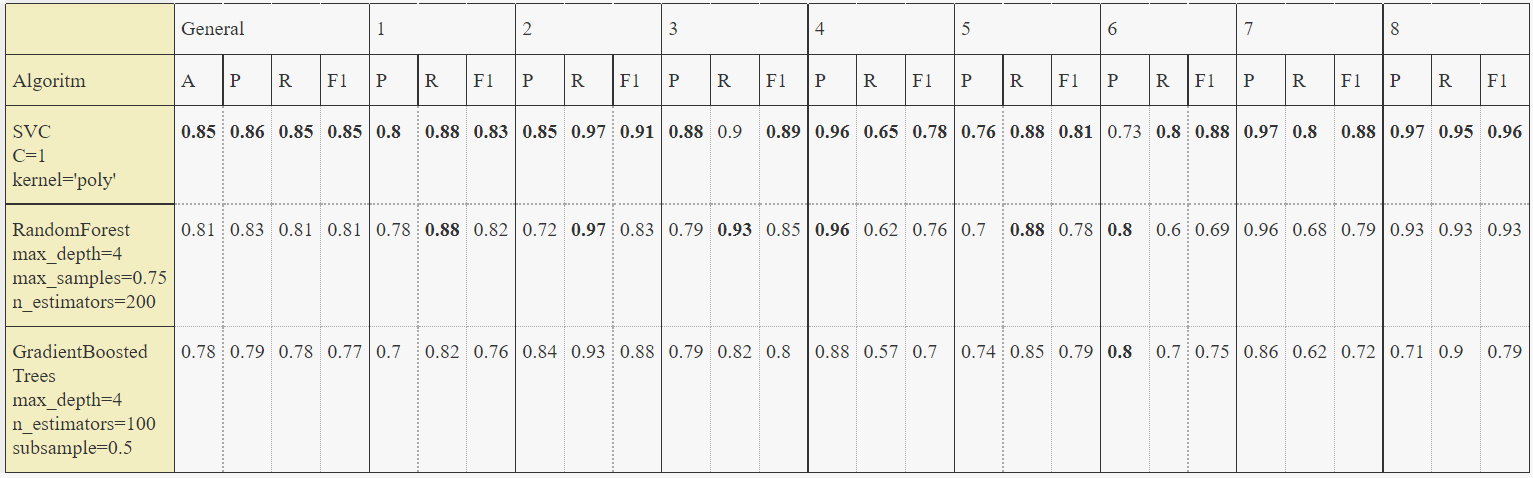

In [ ]:
Image(path + 'results_uwavegestures.PNG')

### Observatii
- Metoda SVC are cele mai bune rezultate. Datele pot fi impartite prin margini de separare.
- Metodele bazate pe arbori de decizie au rezultate suficient de bune, dar usor mai slabe.
- Exista cateva gesturi din cele 8 mai greu de recunoscut, cum ar fi gesturile 5 si 6. Vizual, cele 2 gesturi arata la fel, doar cu componenta y inversata. Acest lucru poate indica ca ele au fost confundate. Asemenator se poate si pentru 3 si 4.

# Cerinta 3 - UWaveGestures

## LSTM

### Converteste input la Tensor

In [18]:
def gestures_to_tensor(x):
  nr, nc = x.shape
  arr = []
  for i in range(nr):
    row = x.iloc[i]
    arr.append(list(zip(row[0], row[1], row[2])))
  return tf.convert_to_tensor(arr)

In [19]:
tf_gst_train_x = gestures_to_tensor(gestures_train_x)
tf_gst_train_y = to_categorical(list(map(lambda str : float(str)-1, gestures_train_y)))
tf_gst_test_x = gestures_to_tensor(gestures_test_x)
tf_gst_test_y = to_categorical(list(map(lambda str : float(str)-1, gestures_test_y)))

### Variatiuni ale modelului

In [ ]:
def gst_define_lstm_model(type='1cell', optimizer='adam'):
  n_examples = gestures_train_x.shape[0]
  n_features = gestures_train_x.shape[1]
  n_timesteps = len(gestures_train_x.iloc[0, 0])

  lstm_model = Sequential()

  if type == '1cell':
    lstm_model.add(LSTM(150, input_shape=(n_timesteps, n_features)))
  elif type == '2cells':
    lstm_model.add(LSTM(100, input_shape=(n_timesteps, n_features), return_sequences=True))
    lstm_model.add(LSTM(50))
  elif type == 'bidir':
    lstm_model.add(Bidirectional(LSTM(150, input_shape=(n_timesteps, n_features))))

  lstm_model.add(Dropout(0.2))
  lstm_model.add(Dense(100, activation='relu'))
  lstm_model.add(Dense(8, activation='softmax'))
  lstm_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return lstm_model

In [ ]:
lstm_1cell = gst_define_lstm_model(type='1cell', optimizer='adam')

In [ ]:
history_lstm_1cell = lstm_1cell.fit(tf_gst_train_x, tf_gst_train_y, epochs=50, batch_size=128, validation_data=(tf_gst_test_x, tf_gst_test_y))

Epoch 1/50
7/7 [==============================] - 21s 3s/step - loss: 1.9312 - accuracy: 0.3237 - val_loss: 1.8016 - val_accuracy: 0.3250
Epoch 2/50
7/7 [==============================] - 17s 3s/step - loss: 1.6406 - accuracy: 0.3661 - val_loss: 1.5299 - val_accuracy: 0.4266
Epoch 3/50
7/7 [==============================] - 17s 3s/step - loss: 1.3829 - accuracy: 0.4978 - val_loss: 1.3818 - val_accuracy: 0.4852
Epoch 4/50
7/7 [==============================] - 17s 3s/step - loss: 1.2523 - accuracy: 0.5391 - val_loss: 1.2421 - val_accuracy: 0.5472
Epoch 5/50
7/7 [==============================] - 17s 3s/step - loss: 1.1488 - accuracy: 0.5603 - val_loss: 1.1615 - val_accuracy: 0.5690
Epoch 6/50
7/7 [==============================] - 17s 3s/step - loss: 1.0558 - accuracy: 0.6161 - val_loss: 1.0869 - val_accuracy: 0.6072
Epoch 7/50
7/7 [==============================] - 17s 3s/step - loss: 0.9592 - accuracy: 0.6752 - val_loss: 0.9706 - val_accuracy: 0.6736
Epoch 8/50
7/7 [==================

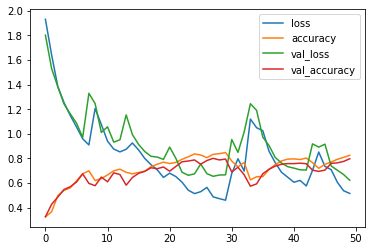

112/112 [==============================] - 13s 113ms/step - loss: 0.6218 - accuracy: 0.7968
0.7967615723609924


In [ ]:
pd.DataFrame(history_lstm_1cell.history).plot()
plt.show()

_, accuracy = lstm_1cell.evaluate(tf_gst_test_x, tf_gst_test_y)
print(accuracy)

In [ ]:
lstm_2cells = gst_define_lstm_model(type='2cells', optimizer='adam')

In [ ]:
history_lstm_2cells = lstm_2cells.fit(tf_gst_train_x, tf_gst_train_y, epochs=50, batch_size=128, validation_data=(tf_gst_test_x, tf_gst_test_y))

Epoch 1/50
7/7 [==============================] - 24s 3s/step - loss: 2.0054 - accuracy: 0.2623 - val_loss: 1.9145 - val_accuracy: 0.3277
Epoch 2/50
7/7 [==============================] - 16s 3s/step - loss: 1.8201 - accuracy: 0.3817 - val_loss: 1.7118 - val_accuracy: 0.4115
Epoch 3/50
7/7 [==============================] - 16s 3s/step - loss: 1.5747 - accuracy: 0.4676 - val_loss: 1.4766 - val_accuracy: 0.4740
Epoch 4/50
7/7 [==============================] - 16s 3s/step - loss: 1.3594 - accuracy: 0.5078 - val_loss: 1.3200 - val_accuracy: 0.5170
Epoch 5/50
7/7 [==============================] - 16s 3s/step - loss: 1.2385 - accuracy: 0.5513 - val_loss: 1.2702 - val_accuracy: 0.5357
Epoch 6/50
7/7 [==============================] - 16s 3s/step - loss: 1.1717 - accuracy: 0.5938 - val_loss: 1.1613 - val_accuracy: 0.5793
Epoch 7/50
7/7 [==============================] - 16s 3s/step - loss: 1.0754 - accuracy: 0.6295 - val_loss: 1.0710 - val_accuracy: 0.6108
Epoch 8/50
7/7 [==================

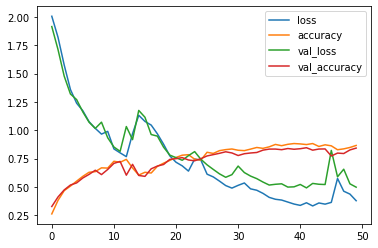

112/112 [==============================] - 14s 124ms/step - loss: 0.4981 - accuracy: 0.8428
0.8428252339363098


In [ ]:
pd.DataFrame(history_lstm_2cells.history).plot()
plt.show()

_, accuracy = lstm_2cells.evaluate(tf_gst_test_x, tf_gst_test_y)
print(accuracy)

In [ ]:
blstm = gst_define_lstm_model(type='bidir', optimizer='adam')

In [ ]:
history_blstm = blstm.fit(tf_gst_train_x, tf_gst_train_y, epochs=50, batch_size=128, validation_data=(tf_gst_test_x, tf_gst_test_y))

Epoch 1/50
7/7 [==============================] - 38s 5s/step - loss: 1.8447 - accuracy: 0.4330 - val_loss: 1.5372 - val_accuracy: 0.5140
Epoch 2/50
7/7 [==============================] - 31s 5s/step - loss: 1.2927 - accuracy: 0.5357 - val_loss: 1.1226 - val_accuracy: 0.5782
Epoch 3/50
7/7 [==============================] - 31s 5s/step - loss: 0.9386 - accuracy: 0.6362 - val_loss: 0.9107 - val_accuracy: 0.6393
Epoch 4/50
7/7 [==============================] - 31s 5s/step - loss: 0.7958 - accuracy: 0.7065 - val_loss: 0.7764 - val_accuracy: 0.7069
Epoch 5/50
7/7 [==============================] - 30s 5s/step - loss: 0.7149 - accuracy: 0.7478 - val_loss: 0.7742 - val_accuracy: 0.7250
Epoch 6/50
7/7 [==============================] - 30s 5s/step - loss: 0.6923 - accuracy: 0.7511 - val_loss: 0.7873 - val_accuracy: 0.7189
Epoch 7/50
7/7 [==============================] - 30s 5s/step - loss: 0.6301 - accuracy: 0.7623 - val_loss: 0.6880 - val_accuracy: 0.7691
Epoch 8/50
7/7 [==================

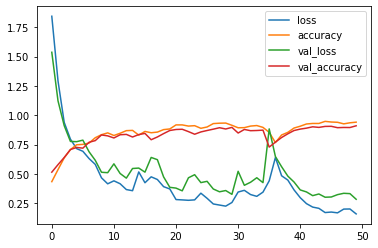

112/112 [==============================] - 15s 136ms/step - loss: 0.2827 - accuracy: 0.9098
0.909826934337616


In [ ]:
pd.DataFrame(history_blstm.history).plot()
plt.show()

_, accuracy = blstm.evaluate(tf_gst_test_x, tf_gst_test_y)
print(accuracy)

In [ ]:
lstm_1cell_pred = lstm_1cell.predict(tf_gst_test_x)
lstm_1cell_pred = list(map(lambda parr : f"{np.argmax(parr)+1}", lstm_1cell_pred))

In [ ]:
print(classification_report(gestures_test_y, lstm_1cell_pred))

              precision    recall  f1-score   support

           1       0.85      0.74      0.79       437
           2       0.87      0.94      0.90       452
           3       0.92      0.85      0.88       454
           4       0.86      0.64      0.73       450
           5       0.72      0.97      0.83       433
           6       0.63      0.54      0.58       449
           7       0.69      0.75      0.72       447
           8       0.85      0.95      0.90       460

    accuracy                           0.80      3582
   macro avg       0.80      0.80      0.79      3582
weighted avg       0.80      0.80      0.79      3582



In [ ]:
lstm_1cell_matrix = confusion_matrix(gestures_test_y, lstm_1cell_pred)
lstm_1cell_matrix_df = pd.DataFrame(
    lstm_1cell_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7", "true:8"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7", "pred:8"]
  )
lstm_1cell_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7,pred:8
true:1,323,35,0,2,0,53,24,0
true:2,16,423,0,0,0,3,8,2
true:3,0,0,385,3,31,7,1,27
true:4,4,0,4,287,79,16,52,8
true:5,0,2,5,2,422,2,0,0
true:6,15,9,20,17,47,242,63,36
true:7,18,17,2,13,2,56,336,3
true:8,2,0,3,8,2,8,1,436


In [ ]:
lstm_2cells_pred = lstm_2cells.predict(tf_gst_test_x)
lstm_2cells_pred = list(map(lambda parr : f"{np.argmax(parr)+1}", lstm_2cells_pred))

In [ ]:
print(classification_report(gestures_test_y, lstm_2cells_pred))

              precision    recall  f1-score   support

           1       0.84      0.75      0.79       437
           2       0.93      0.96      0.95       452
           3       0.86      0.97      0.91       454
           4       0.85      0.81      0.83       450
           5       0.79      0.96      0.87       433
           6       0.67      0.54      0.60       449
           7       0.84      0.84      0.84       447
           8       0.94      0.91      0.92       460

    accuracy                           0.84      3582
   macro avg       0.84      0.84      0.84      3582
weighted avg       0.84      0.84      0.84      3582



In [ ]:
lstm_2cells_matrix = confusion_matrix(gestures_test_y, lstm_1cell_pred)
lstm_2cells_matrix_df = pd.DataFrame(
    lstm_2cells_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7", "true:8"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7", "pred:8"]
  )
lstm_2cells_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7,pred:8
true:1,323,35,0,2,0,53,24,0
true:2,16,423,0,0,0,3,8,2
true:3,0,0,385,3,31,7,1,27
true:4,4,0,4,287,79,16,52,8
true:5,0,2,5,2,422,2,0,0
true:6,15,9,20,17,47,242,63,36
true:7,18,17,2,13,2,56,336,3
true:8,2,0,3,8,2,8,1,436


In [ ]:
blstm_pred = blstm.predict(tf_gst_test_x)
blstm_pred = list(map(lambda parr : f"{np.argmax(parr)+1}", blstm_pred))

In [ ]:
print(classification_report(gestures_test_y, blstm_pred))

              precision    recall  f1-score   support

           1       0.88      0.89      0.89       437
           2       0.99      0.97      0.98       452
           3       0.91      0.93      0.92       454
           4       0.89      0.87      0.88       450
           5       0.86      0.94      0.90       433
           6       0.86      0.77      0.82       449
           7       0.92      0.95      0.93       447
           8       0.97      0.96      0.96       460

    accuracy                           0.91      3582
   macro avg       0.91      0.91      0.91      3582
weighted avg       0.91      0.91      0.91      3582



In [ ]:
blstm_matrix = confusion_matrix(gestures_test_y, blstm_pred)
blstm_matrix_df = pd.DataFrame(
    blstm_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7", "true:8"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7", "pred:8"]
  )
blstm_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7,pred:8
true:1,391,0,0,2,0,27,17,0
true:2,3,437,0,0,0,0,10,2
true:3,3,0,424,0,15,10,2,0
true:4,9,1,3,390,23,15,5,4
true:5,3,0,9,11,406,3,1,0
true:6,34,0,23,16,28,347,0,1
true:7,2,4,4,7,1,0,423,6
true:8,0,0,1,13,1,0,4,441


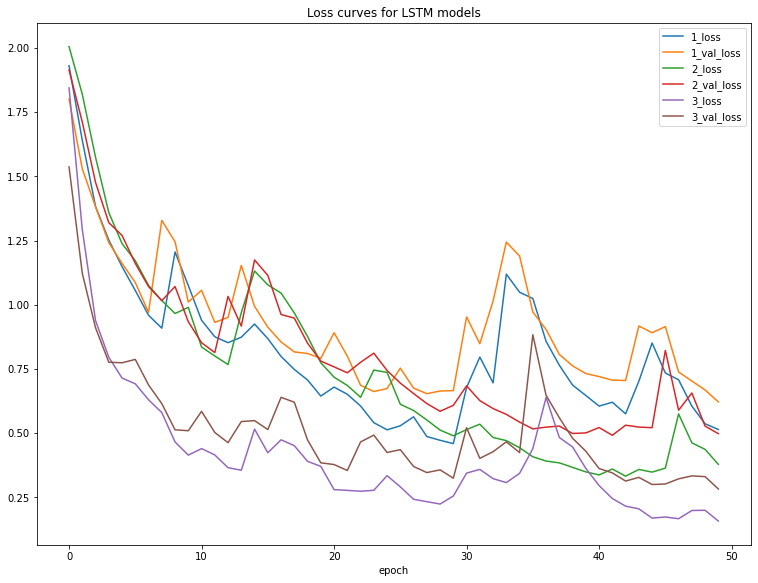

In [ ]:
plt.rcParams['figure.figsize'] = [12.8, 9.6]

plt.plot(history_lstm_1cell.history['loss'], label="1_loss")
plt.plot(history_lstm_1cell.history['val_loss'], label='1_val_loss')
plt.plot(history_lstm_2cells.history['loss'], label="2_loss")
plt.plot(history_lstm_2cells.history['val_loss'], label="2_val_loss")
plt.plot(history_blstm.history['loss'], label="3_loss")
plt.plot(history_blstm.history['val_loss'], label="3_val_loss")
plt.legend()
plt.title("Loss curves for LSTM models")
plt.xlabel("epoch")
plt.show()

plt.rcParams['figure.figsize'] = [6.4, 4.8]

## MLP

In [ ]:
n_examples = gestures_train_x.shape[0]
n_features = gestures_train_x.shape[1]
n_timesteps = len(gestures_train_x.iloc[0, 0])

In [ ]:
mlp_1 = Sequential([
  Flatten(input_shape=(n_timesteps, n_features)),
  Dense(256, activation='sigmoid'),
  Dense(128, activation='sigmoid'),
  Dense(8, activation='softmax')
])
mlp_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_mlp_1 = mlp_1.fit(tf_gst_train_x, tf_gst_train_y, epochs=100, batch_size=128, validation_data=(tf_gst_test_x, tf_gst_test_y))

Epoch 1/100
7/7 [==============================] - 1s 97ms/step - loss: 1.7506 - accuracy: 0.5134 - val_loss: 1.3321 - val_accuracy: 0.7236
Epoch 2/100
7/7 [==============================] - 0s 42ms/step - loss: 1.1290 - accuracy: 0.8013 - val_loss: 0.9826 - val_accuracy: 0.8587
Epoch 3/100
7/7 [==============================] - 0s 42ms/step - loss: 0.8514 - accuracy: 0.8817 - val_loss: 0.7738 - val_accuracy: 0.8763
Epoch 4/100
7/7 [==============================] - 0s 48ms/step - loss: 0.6691 - accuracy: 0.8951 - val_loss: 0.6411 - val_accuracy: 0.8861
Epoch 5/100
7/7 [==============================] - 0s 40ms/step - loss: 0.5503 - accuracy: 0.9129 - val_loss: 0.5552 - val_accuracy: 0.8959
Epoch 6/100
7/7 [==============================] - 0s 70ms/step - loss: 0.4682 - accuracy: 0.9230 - val_loss: 0.4891 - val_accuracy: 0.9056
Epoch 7/100
7/7 [==============================] - 0s 40ms/step - loss: 0.4060 - accuracy: 0.9342 - val_loss: 0.4473 - val_accuracy: 0.9090
Epoch 8/100
7/7 [===

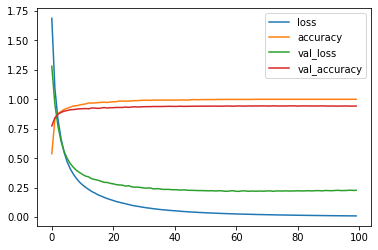

112/112 [==============================] - 0s 2ms/step - loss: 0.2264 - accuracy: 0.9417
0.9416527152061462


In [ ]:
pd.DataFrame(history_mlp_1.history).plot()
plt.show()

_, accuracy = mlp_1.evaluate(tf_gst_test_x, tf_gst_test_y)
print(accuracy)

In [ ]:
mlp_2 = Sequential([
  Flatten(input_shape=(n_timesteps, n_features)),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(8, activation='softmax')
])
mlp_2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
history_mlp_2 = mlp_2.fit(tf_gst_train_x, tf_gst_train_y, epochs=100, batch_size=128, validation_data=(tf_gst_test_x, tf_gst_test_y))

Epoch 1/100
7/7 [==============================] - 2s 263ms/step - loss: 2.0152 - accuracy: 0.2612 - val_loss: 1.4793 - val_accuracy: 0.5402
Epoch 2/100
7/7 [==============================] - 0s 40ms/step - loss: 1.2100 - accuracy: 0.6775 - val_loss: 1.0183 - val_accuracy: 0.7566
Epoch 3/100
7/7 [==============================] - 0s 42ms/step - loss: 0.8558 - accuracy: 0.8170 - val_loss: 0.7857 - val_accuracy: 0.8345
Epoch 4/100
7/7 [==============================] - 0s 41ms/step - loss: 0.6698 - accuracy: 0.8638 - val_loss: 0.6561 - val_accuracy: 0.8599
Epoch 5/100
7/7 [==============================] - 0s 68ms/step - loss: 0.5582 - accuracy: 0.8828 - val_loss: 0.5732 - val_accuracy: 0.8755
Epoch 6/100
7/7 [==============================] - 0s 42ms/step - loss: 0.4838 - accuracy: 0.8984 - val_loss: 0.5178 - val_accuracy: 0.8841
Epoch 7/100
7/7 [==============================] - 0s 69ms/step - loss: 0.4313 - accuracy: 0.9051 - val_loss: 0.4766 - val_accuracy: 0.8906
Epoch 8/100
7/7 [==

In [ ]:
mlp_3 = Sequential([
  Flatten(input_shape=(n_timesteps, n_features)),
  Dense(512, activation='relu'),
  Dropout(0.1),
  Dense(256, activation='relu'),
  Dropout(0.1),
  Dense(128, activation='relu'),
  Dropout(0.1),
  Dense(8, activation='softmax')
])
mlp_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_mlp_3 = mlp_3.fit(tf_gst_train_x, tf_gst_train_y, epochs=100, batch_size=128, validation_data=(tf_gst_test_x, tf_gst_test_y))

Epoch 1/100
7/7 [==============================] - 2s 117ms/step - loss: 0.9206 - accuracy: 0.6953 - val_loss: 0.3692 - val_accuracy: 0.8844
Epoch 2/100
7/7 [==============================] - 0s 68ms/step - loss: 0.2806 - accuracy: 0.9208 - val_loss: 0.2469 - val_accuracy: 0.9310
Epoch 3/100
7/7 [==============================] - 0s 64ms/step - loss: 0.1685 - accuracy: 0.9487 - val_loss: 0.2000 - val_accuracy: 0.9419
Epoch 4/100
7/7 [==============================] - 0s 66ms/step - loss: 0.1219 - accuracy: 0.9598 - val_loss: 0.2409 - val_accuracy: 0.9352
Epoch 5/100
7/7 [==============================] - 0s 68ms/step - loss: 0.0925 - accuracy: 0.9743 - val_loss: 0.2034 - val_accuracy: 0.9430
Epoch 6/100
7/7 [==============================] - 0s 66ms/step - loss: 0.0576 - accuracy: 0.9821 - val_loss: 0.1798 - val_accuracy: 0.9489
Epoch 7/100
7/7 [==============================] - 0s 69ms/step - loss: 0.0366 - accuracy: 0.9911 - val_loss: 0.1947 - val_accuracy: 0.9486
Epoch 8/100
7/7 [==

In [ ]:
mlp_1_pred = mlp_1.predict(tf_gst_test_x)
mlp_1_pred = list(map(lambda parr : f"{np.argmax(parr)+1}", mlp_1_pred))

In [ ]:
print(classification_report(gestures_test_y, mlp_1_pred))

              precision    recall  f1-score   support

           1       0.98      0.94      0.96       437
           2       1.00      0.97      0.98       452
           3       0.96      0.95      0.96       454
           4       0.95      0.90      0.92       450
           5       0.86      0.97      0.91       433
           6       0.88      0.88      0.88       449
           7       0.96      0.97      0.97       447
           8       0.97      0.98      0.98       460

    accuracy                           0.94      3582
   macro avg       0.95      0.94      0.94      3582
weighted avg       0.95      0.94      0.94      3582



In [ ]:
mlp_1_matrix = confusion_matrix(gestures_test_y, mlp_1_pred)
mlp_1_matrix_df = pd.DataFrame(
    mlp_1_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7", "true:8"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7", "pred:8"]
  )
mlp_1_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7,pred:8
true:1,409,0,0,1,0,20,6,1
true:2,1,439,0,0,0,1,9,2
true:3,0,0,431,0,10,10,3,0
true:4,0,0,1,403,24,17,0,5
true:5,2,0,6,1,420,4,0,0
true:6,4,0,6,12,30,394,0,3
true:7,3,1,2,1,0,4,435,1
true:8,0,0,1,4,2,0,0,453


In [ ]:
mlp_2_pred = mlp_2.predict(tf_gst_test_x)
mlp_2_pred = list(map(lambda parr : f"{np.argmax(parr)+1}", mlp_2_pred))

In [ ]:
print(classification_report(gestures_test_y, mlp_2_pred))

              precision    recall  f1-score   support

           1       0.97      0.95      0.96       437
           2       0.98      0.98      0.98       452
           3       0.97      0.93      0.95       454
           4       0.96      0.86      0.91       450
           5       0.85      0.96      0.90       433
           6       0.87      0.89      0.88       449
           7       0.98      0.98      0.98       447
           8       0.98      0.99      0.99       460

    accuracy                           0.94      3582
   macro avg       0.95      0.94      0.94      3582
weighted avg       0.95      0.94      0.94      3582



In [ ]:
mlp_2_matrix = confusion_matrix(gestures_test_y, mlp_2_pred)
mlp_2_matrix_df = pd.DataFrame(
    mlp_2_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7", "true:8"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7", "pred:8"]
  )
mlp_2_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7,pred:8
true:1,416,2,0,0,0,19,0,0
true:2,1,445,0,1,0,1,3,1
true:3,1,2,423,0,9,12,6,1
true:4,2,0,1,387,36,22,0,2
true:5,3,1,7,1,416,4,0,1
true:6,5,1,4,10,26,400,1,2
true:7,1,1,3,1,0,2,439,0
true:8,0,0,0,4,1,0,0,455


In [ ]:
mlp_3_pred = mlp_3.predict(tf_gst_test_x)
mlp_3_pred = list(map(lambda parr : f"{np.argmax(parr)+1}", mlp_3_pred))

In [ ]:
print(classification_report(gestures_test_y, mlp_3_pred))

              precision    recall  f1-score   support

           1       0.97      0.95      0.96       437
           2       1.00      0.99      0.99       452
           3       0.97      0.94      0.95       454
           4       0.94      0.90      0.92       450
           5       0.89      0.97      0.93       433
           6       0.88      0.90      0.89       449
           7       0.99      1.00      0.99       447
           8       0.99      0.99      0.99       460

    accuracy                           0.95      3582
   macro avg       0.95      0.95      0.95      3582
weighted avg       0.95      0.95      0.95      3582



In [ ]:
mlp_3_matrix = confusion_matrix(gestures_test_y, mlp_3_pred)
mlp_3_matrix_df = pd.DataFrame(
    mlp_1_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7", "true:8"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7", "pred:8"]
  )
mlp_3_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7,pred:8
true:1,409,0,0,1,0,20,6,1
true:2,1,439,0,0,0,1,9,2
true:3,0,0,431,0,10,10,3,0
true:4,0,0,1,403,24,17,0,5
true:5,2,0,6,1,420,4,0,0
true:6,4,0,6,12,30,394,0,3
true:7,3,1,2,1,0,4,435,1
true:8,0,0,1,4,2,0,0,453


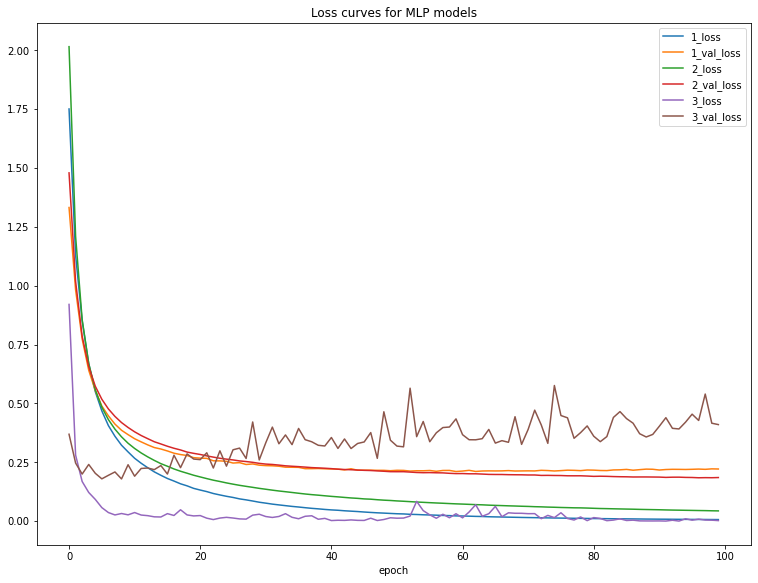

In [ ]:
plt.rcParams['figure.figsize'] = [12.8, 9.6]

plt.plot(history_mlp_1.history['loss'], label="1_loss")
plt.plot(history_mlp_1.history['val_loss'], label='1_val_loss')
plt.plot(history_mlp_2.history['loss'], label="2_loss")
plt.plot(history_mlp_2.history['val_loss'], label="2_val_loss")
plt.plot(history_mlp_3.history['loss'], label="3_loss")
plt.plot(history_mlp_3.history['val_loss'], label="3_val_loss")
plt.legend()
plt.title("Loss curves for MLP models")
plt.xlabel("epoch")
plt.show()

plt.rcParams['figure.figsize'] = [6.4, 4.8]

## Conv

## 1

In [27]:
n_examples = gestures_train_x.shape[0]
n_features = gestures_train_x.shape[1]
n_timesteps = len(gestures_train_x.iloc[0, 0])

In [67]:
conv1 = Sequential([
  Reshape((n_timesteps, n_features), input_shape=(n_timesteps, n_features)),
  Conv1D(256, 5, activation='relu', padding='same', input_shape=(n_timesteps, n_features)),
  GlobalAvgPool1D(),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(8, activation='softmax')
])
conv1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(conv1.output_shape)

(None, 8)


In [68]:
history_conv1 = conv1.fit(tf_gst_train_x, tf_gst_train_y, epochs=100, batch_size=128, validation_data=(tf_gst_test_x, tf_gst_test_y))

Epoch 1/100
7/7 [==============================] - 4s 489ms/step - loss: 2.0610 - accuracy: 0.1808 - val_loss: 2.0365 - val_accuracy: 0.2253
Epoch 2/100
7/7 [==============================] - 2s 294ms/step - loss: 2.0054 - accuracy: 0.2455 - val_loss: 1.9755 - val_accuracy: 0.2448
Epoch 3/100
7/7 [==============================] - 3s 410ms/step - loss: 1.9295 - accuracy: 0.2902 - val_loss: 1.8896 - val_accuracy: 0.3096
Epoch 4/100
7/7 [==============================] - 3s 421ms/step - loss: 1.8321 - accuracy: 0.3516 - val_loss: 1.7972 - val_accuracy: 0.3490
Epoch 5/100
7/7 [==============================] - 2s 381ms/step - loss: 1.7278 - accuracy: 0.3839 - val_loss: 1.7212 - val_accuracy: 0.3568
Epoch 6/100
7/7 [==============================] - 3s 408ms/step - loss: 1.6544 - accuracy: 0.4051 - val_loss: 1.6817 - val_accuracy: 0.3666
Epoch 7/100
7/7 [==============================] - 2s 287ms/step - loss: 1.6122 - accuracy: 0.4007 - val_loss: 1.6499 - val_accuracy: 0.3830
Epoch 8/100
7

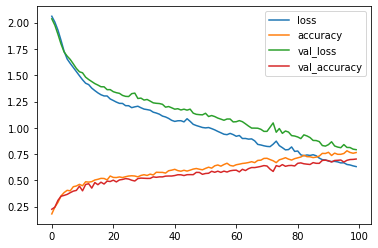

112/112 [==============================] - 1s 10ms/step - loss: 0.7919 - accuracy: 0.7030
0.7029592394828796


In [69]:
pd.DataFrame(history_conv1.history).plot()
plt.show()

_, accuracy = conv1.evaluate(tf_gst_test_x, tf_gst_test_y)
print(accuracy)

In [70]:
conv1_pred = conv1.predict(tf_gst_test_x)
conv1_pred = list(map(lambda parr : f"{np.argmax(parr)+1}", conv1_pred))

In [71]:
print(classification_report(gestures_test_y, conv1_pred))

              precision    recall  f1-score   support

           1       0.61      0.74      0.67       437
           2       0.83      0.85      0.84       452
           3       0.84      0.33      0.47       454
           4       0.56      0.77      0.65       450
           5       0.58      0.61      0.59       433
           6       0.64      0.53      0.58       449
           7       0.77      0.91      0.84       447
           8       0.92      0.88      0.90       460

    accuracy                           0.70      3582
   macro avg       0.72      0.70      0.69      3582
weighted avg       0.72      0.70      0.69      3582



In [72]:
conv1_matrix = confusion_matrix(gestures_test_y, conv1_pred)
conv1_matrix_df = pd.DataFrame(
    conv1_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7", "true:8"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7", "pred:8"]
  )
conv1_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7,pred:8
true:1,325,26,2,27,24,3,28,2
true:2,40,383,0,0,0,2,25,2
true:3,52,6,148,187,15,8,12,26
true:4,38,2,10,347,19,8,23,3
true:5,23,8,4,7,263,111,17,0
true:6,33,3,7,25,124,240,15,2
true:7,8,8,0,19,0,4,408,0
true:8,10,28,5,3,9,0,1,404


## 2

In [78]:
no_windows = 9
size_window = 35

In [92]:
conv2 = Sequential([
  Reshape((size_window, n_features * no_windows), input_shape=(n_timesteps, n_features)),
  Conv1D(64, 5, activation='relu', padding='same', input_shape=(size_window, n_features * no_windows)),
  Conv1D(32, 3, activation='relu'),
  GlobalAvgPool1D(),
  Dense(256, activation='sigmoid'),
  Dense(128, activation='sigmoid'),
  Dense(8, activation='softmax')
])
conv2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(conv2.output_shape)

(None, 33, 32)


In [85]:
history_conv2 = conv2.fit(tf_gst_train_x, tf_gst_train_y, epochs=100, batch_size=128, validation_data=(tf_gst_test_x, tf_gst_test_y))

Epoch 1/100
7/7 [==============================] - 2s 140ms/step - loss: 2.1504 - accuracy: 0.1272 - val_loss: 2.1092 - val_accuracy: 0.1220
Epoch 2/100
7/7 [==============================] - 1s 81ms/step - loss: 2.0903 - accuracy: 0.1094 - val_loss: 2.0871 - val_accuracy: 0.1209
Epoch 3/100
7/7 [==============================] - 1s 115ms/step - loss: 2.0611 - accuracy: 0.1518 - val_loss: 2.0448 - val_accuracy: 0.2091
Epoch 4/100
7/7 [==============================] - 1s 120ms/step - loss: 2.0270 - accuracy: 0.2199 - val_loss: 2.0015 - val_accuracy: 0.2686
Epoch 5/100
7/7 [==============================] - 0s 64ms/step - loss: 1.9657 - accuracy: 0.2857 - val_loss: 1.9370 - val_accuracy: 0.2638
Epoch 6/100
7/7 [==============================] - 0s 60ms/step - loss: 1.8750 - accuracy: 0.3237 - val_loss: 1.8391 - val_accuracy: 0.3492
Epoch 7/100
7/7 [==============================] - 0s 53ms/step - loss: 1.7665 - accuracy: 0.4576 - val_loss: 1.7272 - val_accuracy: 0.5302
Epoch 8/100
7/7 [

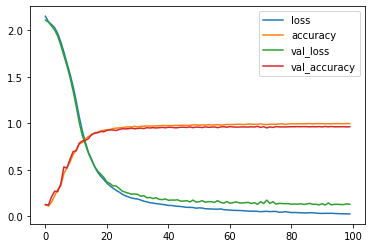

112/112 [==============================] - 0s 3ms/step - loss: 0.1287 - accuracy: 0.9620
0.9620323777198792


In [86]:
pd.DataFrame(history_conv2.history).plot()
plt.show()

_, accuracy = conv2.evaluate(tf_gst_test_x, tf_gst_test_y)
print(accuracy)

In [87]:
conv2_pred = conv2.predict(tf_gst_test_x)
conv2_pred = list(map(lambda parr : f"{np.argmax(parr)+1}", conv2_pred))

In [88]:
print(classification_report(gestures_test_y, conv2_pred))

              precision    recall  f1-score   support

           1       0.96      0.98      0.97       437
           2       1.00      1.00      1.00       452
           3       0.98      0.93      0.95       454
           4       0.95      0.93      0.94       450
           5       0.90      0.98      0.94       433
           6       0.96      0.91      0.93       449
           7       0.96      1.00      0.98       447
           8       1.00      0.98      0.99       460

    accuracy                           0.96      3582
   macro avg       0.96      0.96      0.96      3582
weighted avg       0.96      0.96      0.96      3582



In [93]:
conv2_matrix = confusion_matrix(gestures_test_y, conv2_pred)
conv2_matrix_df = pd.DataFrame(
    conv2_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7", "true:8"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7", "pred:8"]
  )
conv2_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7,pred:8
true:1,427,0,1,5,0,4,0,0
true:2,1,451,0,0,0,0,0,0
true:3,2,0,421,7,6,10,6,2
true:4,9,0,0,418,18,3,2,0
true:5,1,0,4,2,424,1,1,0
true:6,4,0,3,4,21,409,8,0
true:7,0,0,1,1,0,0,445,0
true:8,3,0,0,4,0,1,1,451


## 3

In [100]:
no_windows = 3
size_window = 105

In [101]:
conv3 = Sequential([
  Reshape((size_window, n_features * no_windows), input_shape=(n_timesteps, n_features)),
  Conv1D(128, 5, activation='relu', padding='same', input_shape=(size_window, n_features * no_windows)),
  Conv1D(64, 3, activation='relu'),
  GlobalAvgPool1D(),
  Dense(64, activation='relu'),
  Dense(32, activation='relu'),
  Dense(8, activation='softmax')
])
conv3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(conv3.output_shape)

(None, 8)


In [102]:
history_conv3 = conv3.fit(tf_gst_train_x, tf_gst_train_y, epochs=100, batch_size=128, validation_data=(tf_gst_test_x, tf_gst_test_y))

Epoch 1/100
7/7 [==============================] - 2s 253ms/step - loss: 2.0718 - accuracy: 0.1350 - val_loss: 2.0486 - val_accuracy: 0.2289
Epoch 2/100
7/7 [==============================] - 1s 229ms/step - loss: 2.0308 - accuracy: 0.2121 - val_loss: 2.0030 - val_accuracy: 0.2353
Epoch 3/100
7/7 [==============================] - 1s 227ms/step - loss: 1.9732 - accuracy: 0.2667 - val_loss: 1.9401 - val_accuracy: 0.3476
Epoch 4/100
7/7 [==============================] - 1s 229ms/step - loss: 1.8938 - accuracy: 0.3795 - val_loss: 1.8547 - val_accuracy: 0.3783
Epoch 5/100
7/7 [==============================] - 1s 230ms/step - loss: 1.7840 - accuracy: 0.4397 - val_loss: 1.7287 - val_accuracy: 0.4939
Epoch 6/100
7/7 [==============================] - 1s 219ms/step - loss: 1.6357 - accuracy: 0.5346 - val_loss: 1.6172 - val_accuracy: 0.4712
Epoch 7/100
7/7 [==============================] - 1s 225ms/step - loss: 1.5238 - accuracy: 0.5279 - val_loss: 1.5145 - val_accuracy: 0.4771
Epoch 8/100
7

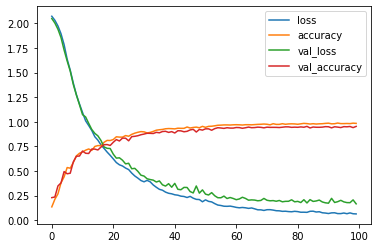

112/112 [==============================] - 1s 8ms/step - loss: 0.1657 - accuracy: 0.9525
0.9525404572486877


In [103]:
pd.DataFrame(history_conv3.history).plot()
plt.show()

_, accuracy = conv3.evaluate(tf_gst_test_x, tf_gst_test_y)
print(accuracy)

In [104]:
conv3_pred = conv3.predict(tf_gst_test_x)
conv3_pred = list(map(lambda parr : f"{np.argmax(parr)+1}", conv3_pred))

In [105]:
print(classification_report(gestures_test_y, conv3_pred))

              precision    recall  f1-score   support

           1       0.92      0.95      0.94       437
           2       0.98      0.98      0.98       452
           3       0.92      0.95      0.93       454
           4       0.93      0.94      0.93       450
           5       0.95      0.97      0.96       433
           6       0.97      0.90      0.93       449
           7       0.96      0.95      0.95       447
           8       0.99      0.98      0.99       460

    accuracy                           0.95      3582
   macro avg       0.95      0.95      0.95      3582
weighted avg       0.95      0.95      0.95      3582



In [99]:
conv3_matrix = confusion_matrix(gestures_test_y, conv3_pred)
conv3_matrix_df = pd.DataFrame(
    conv3_matrix,
    index=["true:1", "true:2", "true:3", "true:4", "true:5", "true:6", "true:7", "true:8"],
    columns=["pred:1", "pred:2", "pred:3", "pred:4", "pred:5", "pred:6", "pred:7", "pred:8"]
  )
conv3_matrix_df

,pred:1,pred:2,pred:3,pred:4,pred:5,pred:6,pred:7,pred:8
true:1,332,21,9,29,1,8,21,16
true:2,14,415,4,6,8,2,3,0
true:3,31,8,245,107,11,19,12,21
true:4,28,5,114,244,22,7,4,26
true:5,5,12,6,8,296,89,16,1
true:6,17,10,14,21,125,239,13,10
true:7,18,16,24,5,4,3,288,89
true:8,11,6,8,25,3,5,52,350


## Rezultate CNN

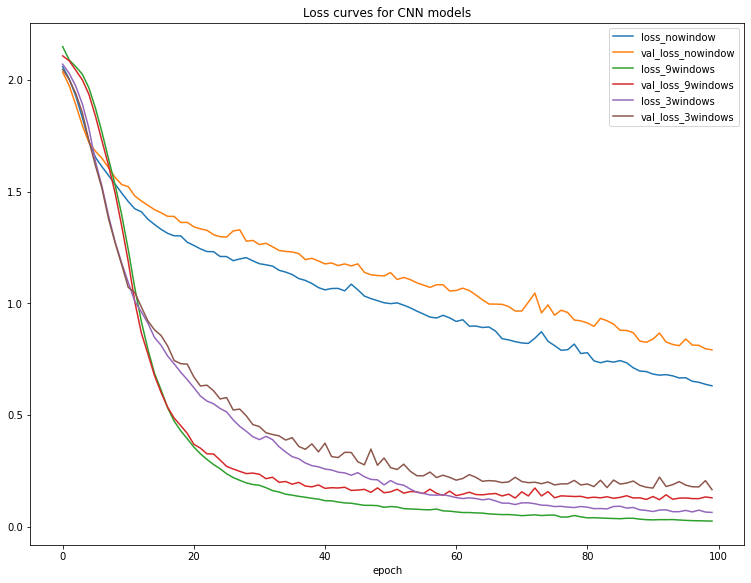

In [106]:
plt.rcParams['figure.figsize'] = [12.8, 9.6]

plt.plot(history_conv1.history['loss'], label="loss_nowindow")
plt.plot(history_conv1.history['val_loss'], label='val_loss_nowindow')
plt.plot(history_conv2.history['loss'], label="loss_9windows")
plt.plot(history_conv2.history['val_loss'], label="val_loss_9windows")
plt.plot(history_conv3.history['loss'], label="loss_3windows")
plt.plot(history_conv3.history['val_loss'], label="val_loss_3windows")
plt.legend()
plt.title("Loss curves for CNN models")
plt.xlabel("epoch")
plt.show()

plt.rcParams['figure.figsize'] = [6.4, 4.8]